In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [2]:
tf.keras.backend.set_floatx('float32')

In [3]:
from tensorflow.keras import layers

In [4]:
import pettingzoo
from pettingzoo.mpe import simple_spread_v1

In [5]:
env =simple_spread_v1.parallel_env(max_frames=100)


C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:

upper_bound = 1
lower_bound = -1

In [7]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

In [9]:
class Agent:
    def __init__(self, buffer_capacity=5, batch_size=3):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0

        self.state_buffer1 = np.zeros((self.buffer_capacity, 18))
        self.action_buffer1 = np.zeros((self.buffer_capacity, 2))
        self.next_state_buffer1=np.zeros((self.buffer_capacity,18))
        self.reward_buffer1=np.zeros((self.buffer_capacity,1))
        
        self.state_buffer2 = np.zeros((self.buffer_capacity, 18))
        self.action_buffer2 = np.zeros((self.buffer_capacity, 2))
        self.next_state_buffer2=np.zeros((self.buffer_capacity,18))
        self.reward_buffer2=np.zeros((self.buffer_capacity,1))
        
        self.state_buffer3 = np.zeros((self.buffer_capacity, 18))
        self.action_buffer3 = np.zeros((self.buffer_capacity, 2))
        self.next_state_buffer3=np.zeros((self.buffer_capacity,18))
        self.reward_buffer3=np.zeros((self.buffer_capacity,1))
        
        self.state_batches={'agent_0':0,'agent_1':2,'agent_2':0}
        self.action_batches={'agent_0':0,'agent_1':0,'agent_2':0}
        self.next_state_batches={'agent_0':0,'agent_1':0,'agent_2':0}
        self.reward_batches={'agent_0':0,'agent_1':0,'agent_2':0}
        
        self.state_buffers={'agent_0':self.state_buffer1,'agent_1':self.state_buffer2,'agent_2':self.state_buffer3}
        self.action_buffers={'agent_0':self.action_buffer1,'agent_1':self.action_buffer2,'agent_2':self.action_buffer3}
        self.next_state_buffers={'agent_0':self.next_state_buffer1,'agent_1':self.next_state_buffer2,'agent_2':self.next_state_buffer3}
        self.reward_buffers={'agent_0':self.reward_buffer1,'agent_1':self.reward_buffer2,'agent_2':self.reward_buffer3}
        
        self.target_actor1=get_actor()
        self.target_actor2=get_actor()
        self.target_actor3=get_actor()
        self.target_actor_models={'agent_0':self.target_actor1,'agent_1':self.target_actor2,'agent_2':self.target_actor3}
        
        self.target_critic = get_critic()
        self.critic=get_critic()
        self.target_critic.set_weights(self.critic.get_weights())
        
        self.actor1=get_actor()
        self.actor2=get_actor()
        self.actor3=get_actor()
        self.actor_models={'agent_0':self.actor1,'agent_1':self.actor2,'agent_2':self.actor3}
        
        self.critic_lr = 0.002
        self.actor_lr = 0.001
        self.gamma=0.99
        self.tau=0.005
        self.epsilon=1
        self.episode_steps=0
        self.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0} 
        self.upper_bound=1
        self.lower_bound=-1
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_lr)
        
        for agent in env.agents:
            self.target_actor_models[agent].set_weights(self.actor_models[agent].get_weights())
    
    
    
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        for agent in env.agents:
            self.state_buffers[agent][index]=obs_tuple[0][agent]
            self.action_buffers[agent][index]=obs_tuple[1][agent]
            self.reward_buffers[agent][index]=obs_tuple[2][agent]
            self.next_state_buffers[agent][index]=obs_tuple[3][agent]
        self.buffer_counter += 1
        
        

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)
        for agent in self.state_batches:
            self.state_batches[agent]=tf.convert_to_tensor(self.state_buffers[agent][batch_indices],dtype=tf.float32)
            self.action_batches[agent]=tf.convert_to_tensor(self.action_buffers[agent][batch_indices],dtype=tf.float32)
            self.next_state_batches[agent]=tf.convert_to_tensor(self.next_state_buffers[agent][batch_indices],dtype=tf.float32)
            self.reward_batches[agent]=tf.convert_to_tensor(self.reward_buffers[agent][batch_indices],dtype=tf.float32)
            
        self.update()
    def update(self):
        states=[]
        actions=[]
        next_states=[]
        rewards=[]
        target_actions=[]
        action_batch=[]
        for agent in env.agents:
            states.append(self.state_batches[agent])
            actions.append(self.action_batches[agent])
            next_states.append(self.next_state_batches[agent])
            rewards.append(self.reward_batches[agent])
            
        with tf.GradientTape() as tape:
            for agent in env.agents:
                actions_=self.target_actor_models[agent](self.next_state_batches[agent], training=True)
                actions_=tf.reshape(actions_,(self.batch_size,-1))
                target_actions.append(actions_)
            y = rewards + self.gamma * self.target_critic([next_states, target_actions], training=True)
            critic_value = self.critic([states, actions], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            critic_grad = tape.gradient(critic_loss,self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(
            zip(critic_grad,self.critic.trainable_variables)
        )
        with tf.GradientTape(persistent=True) as tape:
            for agent in env.agents:
                action_batch.append(self.actor_models[agent](self.state_batches[agent], training=True))
            
            critic_value = self.critic([states, action_batch], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)
            
            for agent in env.agents:
                actor_grad = tape.gradient(actor_loss,self.actor_models[agent].trainable_variables)
                self.actor_optimizer.apply_gradients(zip(actor_grad,self.actor_models[agent].trainable_variables))
    
                                    
                                    
    def policy(self,agent,state,noise_object):
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        sampled_actions = tf.squeeze(self.actor_models[agent](state))
        noise = noise_object()
        sampled_actions = sampled_actions.numpy() + noise
        sampled_actions=np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return sampled_actions
    
    @tf.function
    def update_target(self,target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))
    

In [10]:
def get_critic():
    tf.keras.backend.set_floatx('float64')
    state_input1=layers.Input(shape=(18))
    state_input2=layers.Input(shape=(18))
    state_input3=layers.Input(shape=(18))
    state_input=layers.Concatenate()([state_input1,state_input2,state_input3])
    state_output=layers.Dense(32,activation='relu')(state_input)
    
    
    action_input=layers.Input(shape=(2))
    
    action_input1=layers.Input(shape=(2))
    action_input2=layers.Input(shape=(2))
    action_input3=layers.Input(shape=(2))
    action_input=layers.Concatenate()([action_input1,action_input2,action_input3])
    action_output=layers.Dense(32,activation='relu')(action_input)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input1,state_input2,state_input3,action_input1,action_input2,action_input3],x)
    return model

In [11]:
def get_actor():
    tf.keras.backend.set_floatx('float64')
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(18))
    x=layers.Dense(256,activation='relu')(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(2,activation='tanh')(x)
    model=tf.keras.Model(i,x)
    return model

In [25]:
agent1=Agent(50000,64)

In [26]:
tf.keras.backend.set_floatx('float32')

In [28]:
ep_reward_list = []

episode_steps=[]

for episode in range(5000):

    last_states = env.reset()
    agent1.sum_rewards = {'agent_0':0,'agent_1':0,'agent_2':0}
    agent1.episode_steps=0
    while True:
   
        actions = {agent: agent1.policy(agent,last_states[agent],ou_noise) for agent in env.agents}
        next_states,rewards,done,info=env.step(actions)
        
             
        agent1.sum_rewards={agent: (agent1.sum_rewards[agent]+rewards[agent]) for agent in rewards}
        agent1.episode_steps+=1
        
        agent1.record((last_states,actions,rewards,next_states))
        agent1.learn()
   
        
        for agent in rewards:
            agent1.update_target(agent1.target_actor_models[agent].variables,agent1.actor_models[agent].variables)
        
        agent1.update_target(agent1.target_critic.variables,agent1.critic.variables)
        
        if done['agent_0']:
            break
        last_states=next_states
    
    print("EPISODE ",episode," STEPS = ",agent1.episode_steps)
    print("REWARD ",agent1.sum_rewards)
        
    ep_reward_list.append(agent1.sum_rewards)
    episode_steps.append(agent1.episode_steps)
        

EPISODE  0  STEPS =  102
REWARD  {'agent_0': -3588.0696041689453, 'agent_1': -3588.0696041689453, 'agent_2': -3588.0696041689453}
EPISODE  1  STEPS =  102
REWARD  {'agent_0': -6494.924021858959, 'agent_1': -6494.924021858959, 'agent_2': -6494.924021858959}
EPISODE  2  STEPS =  102
REWARD  {'agent_0': -5895.989662898006, 'agent_1': -5895.989662898006, 'agent_2': -5895.989662898006}
EPISODE  3  STEPS =  102
REWARD  {'agent_0': -2132.271900555492, 'agent_1': -2132.771900555492, 'agent_2': -2132.771900555492}
EPISODE  4  STEPS =  102
REWARD  {'agent_0': -2170.642448680008, 'agent_1': -2170.642448680008, 'agent_2': -2170.642448680008}
EPISODE  5  STEPS =  102
REWARD  {'agent_0': -2175.7711207184157, 'agent_1': -2175.7711207184157, 'agent_2': -2175.7711207184157}
EPISODE  6  STEPS =  102
REWARD  {'agent_0': -2005.7257218985662, 'agent_1': -2005.7257218985662, 'agent_2': -2005.7257218985662}
EPISODE  7  STEPS =  102
REWARD  {'agent_0': -2143.382050318609, 'agent_1': -2143.382050318609, 'agent

EPISODE  64  STEPS =  102
REWARD  {'agent_0': -1729.457744186288, 'agent_1': -1729.457744186288, 'agent_2': -1729.457744186288}
EPISODE  65  STEPS =  102
REWARD  {'agent_0': -1210.7706754248516, 'agent_1': -1210.7706754248516, 'agent_2': -1210.7706754248516}
EPISODE  66  STEPS =  102
REWARD  {'agent_0': -1648.6767048500744, 'agent_1': -1649.1767048500744, 'agent_2': -1649.1767048500744}
EPISODE  67  STEPS =  102
REWARD  {'agent_0': -1458.4769472184823, 'agent_1': -1458.4769472184823, 'agent_2': -1458.4769472184823}
EPISODE  68  STEPS =  102
REWARD  {'agent_0': -1544.101835924551, 'agent_1': -1545.101835924551, 'agent_2': -1544.601835924551}
EPISODE  69  STEPS =  102
REWARD  {'agent_0': -1809.831830273304, 'agent_1': -1809.831830273304, 'agent_2': -1809.331830273304}
EPISODE  70  STEPS =  102
REWARD  {'agent_0': -2452.7283564259, 'agent_1': -2451.2283564259, 'agent_2': -2452.2283564259}
EPISODE  71  STEPS =  102
REWARD  {'agent_0': -2059.064435655523, 'agent_1': -2059.564435655523, 'age

EPISODE  128  STEPS =  102
REWARD  {'agent_0': -1645.885892644851, 'agent_1': -1645.885892644851, 'agent_2': -1645.885892644851}
EPISODE  129  STEPS =  102
REWARD  {'agent_0': -2299.203278512833, 'agent_1': -2298.203278512833, 'agent_2': -2299.203278512833}
EPISODE  130  STEPS =  102
REWARD  {'agent_0': -1655.8850259462924, 'agent_1': -1655.8850259462924, 'agent_2': -1655.8850259462924}
EPISODE  131  STEPS =  102
REWARD  {'agent_0': -2241.9399188870048, 'agent_1': -2241.9399188870048, 'agent_2': -2241.9399188870048}
EPISODE  132  STEPS =  102
REWARD  {'agent_0': -2033.810326220526, 'agent_1': -2033.810326220526, 'agent_2': -2033.810326220526}
EPISODE  133  STEPS =  102
REWARD  {'agent_0': -2187.0020389704896, 'agent_1': -2187.0020389704896, 'agent_2': -2187.0020389704896}
EPISODE  134  STEPS =  102
REWARD  {'agent_0': -2130.4233048083497, 'agent_1': -2130.4233048083497, 'agent_2': -2130.4233048083497}
EPISODE  135  STEPS =  102
REWARD  {'agent_0': -2064.9982814231444, 'agent_1': -2064.

EPISODE  191  STEPS =  102
REWARD  {'agent_0': -1950.0541598797245, 'agent_1': -1950.0541598797245, 'agent_2': -1950.0541598797245}
EPISODE  192  STEPS =  102
REWARD  {'agent_0': -872.5225243090945, 'agent_1': -872.5225243090945, 'agent_2': -872.5225243090945}
EPISODE  193  STEPS =  102
REWARD  {'agent_0': -1723.3430092855058, 'agent_1': -1723.3430092855058, 'agent_2': -1723.3430092855058}
EPISODE  194  STEPS =  102
REWARD  {'agent_0': -1237.0128768111585, 'agent_1': -1237.0128768111585, 'agent_2': -1237.0128768111585}
EPISODE  195  STEPS =  102
REWARD  {'agent_0': -1118.9357317224815, 'agent_1': -1118.9357317224815, 'agent_2': -1118.9357317224815}
EPISODE  196  STEPS =  102
REWARD  {'agent_0': -1947.9314275351255, 'agent_1': -1947.9314275351255, 'agent_2': -1947.9314275351255}
EPISODE  197  STEPS =  102
REWARD  {'agent_0': -2134.670286455134, 'agent_1': -2134.670286455134, 'agent_2': -2134.670286455134}
EPISODE  198  STEPS =  102
REWARD  {'agent_0': -2363.6505162830813, 'agent_1': -23

EPISODE  254  STEPS =  102
REWARD  {'agent_0': -1624.6395025450688, 'agent_1': -1623.6395025450688, 'agent_2': -1624.1395025450688}
EPISODE  255  STEPS =  102
REWARD  {'agent_0': -1420.8052106416535, 'agent_1': -1420.8052106416535, 'agent_2': -1420.8052106416535}
EPISODE  256  STEPS =  102
REWARD  {'agent_0': -1374.8162912928417, 'agent_1': -1374.8162912928417, 'agent_2': -1374.8162912928417}
EPISODE  257  STEPS =  102
REWARD  {'agent_0': -922.5601731929637, 'agent_1': -922.5601731929637, 'agent_2': -922.5601731929637}
EPISODE  258  STEPS =  102
REWARD  {'agent_0': -1199.2866869154811, 'agent_1': -1199.2866869154811, 'agent_2': -1199.2866869154811}
EPISODE  259  STEPS =  102
REWARD  {'agent_0': -4666.360326273595, 'agent_1': -4666.360326273595, 'agent_2': -4665.360326273595}
EPISODE  260  STEPS =  102
REWARD  {'agent_0': -1621.9652272470667, 'agent_1': -1621.9652272470667, 'agent_2': -1621.9652272470667}
EPISODE  261  STEPS =  102
REWARD  {'agent_0': -1767.6375693781424, 'agent_1': -17

EPISODE  317  STEPS =  102
REWARD  {'agent_0': -1526.6027965725164, 'agent_1': -1525.6027965725164, 'agent_2': -1526.6027965725164}
EPISODE  318  STEPS =  102
REWARD  {'agent_0': -1316.0405237524653, 'agent_1': -1316.0405237524653, 'agent_2': -1316.0405237524653}
EPISODE  319  STEPS =  102
REWARD  {'agent_0': -1905.6686723476917, 'agent_1': -1905.6686723476917, 'agent_2': -1905.6686723476917}
EPISODE  320  STEPS =  102
REWARD  {'agent_0': -1912.0288055851574, 'agent_1': -1911.5288055851574, 'agent_2': -1911.5288055851574}
EPISODE  321  STEPS =  102
REWARD  {'agent_0': -2207.862254601931, 'agent_1': -2207.862254601931, 'agent_2': -2207.862254601931}
EPISODE  322  STEPS =  102
REWARD  {'agent_0': -2128.3552824468884, 'agent_1': -2128.3552824468884, 'agent_2': -2128.3552824468884}
EPISODE  323  STEPS =  102
REWARD  {'agent_0': -2365.893521288849, 'agent_1': -2364.893521288849, 'agent_2': -2365.893521288849}
EPISODE  324  STEPS =  102
REWARD  {'agent_0': -2149.2686620154122, 'agent_1': -21

EPISODE  380  STEPS =  102
REWARD  {'agent_0': -1368.3684413363655, 'agent_1': -1368.3684413363655, 'agent_2': -1368.3684413363655}
EPISODE  381  STEPS =  102
REWARD  {'agent_0': -973.0209177149109, 'agent_1': -973.0209177149109, 'agent_2': -973.0209177149109}
EPISODE  382  STEPS =  102
REWARD  {'agent_0': -1017.0805824674676, 'agent_1': -1017.0805824674676, 'agent_2': -1017.0805824674676}
EPISODE  383  STEPS =  102
REWARD  {'agent_0': -641.0684278397305, 'agent_1': -641.0684278397305, 'agent_2': -641.0684278397305}
EPISODE  384  STEPS =  102
REWARD  {'agent_0': -1008.6427788418663, 'agent_1': -1008.6427788418663, 'agent_2': -1008.6427788418663}
EPISODE  385  STEPS =  102
REWARD  {'agent_0': -1737.1521460950387, 'agent_1': -1737.1521460950387, 'agent_2': -1737.1521460950387}
EPISODE  386  STEPS =  102
REWARD  {'agent_0': -1985.399761294221, 'agent_1': -1985.399761294221, 'agent_2': -1984.399761294221}
EPISODE  387  STEPS =  102
REWARD  {'agent_0': -1311.387760286524, 'agent_1': -1311.3

EPISODE  443  STEPS =  102
REWARD  {'agent_0': -1825.8279368496242, 'agent_1': -1825.8279368496242, 'agent_2': -1824.8279368496242}
EPISODE  444  STEPS =  102
REWARD  {'agent_0': -2145.838447595089, 'agent_1': -2145.838447595089, 'agent_2': -2145.838447595089}
EPISODE  445  STEPS =  102
REWARD  {'agent_0': -1937.7119595442382, 'agent_1': -1938.7119595442382, 'agent_2': -1937.7119595442382}
EPISODE  446  STEPS =  102
REWARD  {'agent_0': -2254.5282375799484, 'agent_1': -2254.5282375799484, 'agent_2': -2254.5282375799484}
EPISODE  447  STEPS =  102
REWARD  {'agent_0': -2238.503302172973, 'agent_1': -2238.503302172973, 'agent_2': -2238.503302172973}
EPISODE  448  STEPS =  102
REWARD  {'agent_0': -1923.0577219521306, 'agent_1': -1923.0577219521306, 'agent_2': -1922.0577219521306}
EPISODE  449  STEPS =  102
REWARD  {'agent_0': -1732.0474517055277, 'agent_1': -1732.0474517055277, 'agent_2': -1732.0474517055277}
EPISODE  450  STEPS =  102
REWARD  {'agent_0': -2083.4610816471763, 'agent_1': -20

EPISODE  506  STEPS =  102
REWARD  {'agent_0': -1886.6489281070878, 'agent_1': -1886.6489281070878, 'agent_2': -1886.1489281070878}
EPISODE  507  STEPS =  102
REWARD  {'agent_0': -2218.118412479258, 'agent_1': -2218.118412479258, 'agent_2': -2218.118412479258}
EPISODE  508  STEPS =  102
REWARD  {'agent_0': -2042.0725462229461, 'agent_1': -2042.0725462229461, 'agent_2': -2042.0725462229461}
EPISODE  509  STEPS =  102
REWARD  {'agent_0': -2153.891470115933, 'agent_1': -2153.391470115933, 'agent_2': -2153.891470115933}
EPISODE  510  STEPS =  102
REWARD  {'agent_0': -2043.1338249830412, 'agent_1': -2044.1338249830412, 'agent_2': -2044.1338249830412}
EPISODE  511  STEPS =  102
REWARD  {'agent_0': -2157.7733836758052, 'agent_1': -2156.7733836758052, 'agent_2': -2157.7733836758052}
EPISODE  512  STEPS =  102
REWARD  {'agent_0': -2217.0267213206416, 'agent_1': -2217.0267213206416, 'agent_2': -2217.0267213206416}
EPISODE  513  STEPS =  102
REWARD  {'agent_0': -2319.4563081439796, 'agent_1': -23

EPISODE  569  STEPS =  102
REWARD  {'agent_0': -1612.77100065603, 'agent_1': -1612.77100065603, 'agent_2': -1612.77100065603}
EPISODE  570  STEPS =  102
REWARD  {'agent_0': -1743.3694927077468, 'agent_1': -1743.3694927077468, 'agent_2': -1743.3694927077468}
EPISODE  571  STEPS =  102
REWARD  {'agent_0': -1277.3382206311398, 'agent_1': -1276.8382206311398, 'agent_2': -1277.3382206311398}
EPISODE  572  STEPS =  102
REWARD  {'agent_0': -1809.5437300752042, 'agent_1': -1809.5437300752042, 'agent_2': -1809.5437300752042}
EPISODE  573  STEPS =  102
REWARD  {'agent_0': -2096.71961484257, 'agent_1': -2096.71961484257, 'agent_2': -2096.71961484257}
EPISODE  574  STEPS =  102
REWARD  {'agent_0': -2220.583490882976, 'agent_1': -2220.583490882976, 'agent_2': -2220.583490882976}
EPISODE  575  STEPS =  102
REWARD  {'agent_0': -2259.661610386205, 'agent_1': -2259.661610386205, 'agent_2': -2259.661610386205}
EPISODE  576  STEPS =  102
REWARD  {'agent_0': -2269.6715856690225, 'agent_1': -2269.671585669

EPISODE  632  STEPS =  102
REWARD  {'agent_0': -1798.9246078369692, 'agent_1': -1798.9246078369692, 'agent_2': -1798.9246078369692}
EPISODE  633  STEPS =  102
REWARD  {'agent_0': -2114.415708848008, 'agent_1': -2114.415708848008, 'agent_2': -2114.415708848008}
EPISODE  634  STEPS =  102
REWARD  {'agent_0': -2171.946574626872, 'agent_1': -2171.946574626872, 'agent_2': -2171.946574626872}
EPISODE  635  STEPS =  102
REWARD  {'agent_0': -1981.838405737295, 'agent_1': -1981.838405737295, 'agent_2': -1981.838405737295}
EPISODE  636  STEPS =  102
REWARD  {'agent_0': -1979.2065606776357, 'agent_1': -1979.2065606776357, 'agent_2': -1979.2065606776357}
EPISODE  637  STEPS =  102
REWARD  {'agent_0': -2042.7209523229399, 'agent_1': -2042.7209523229399, 'agent_2': -2042.7209523229399}
EPISODE  638  STEPS =  102
REWARD  {'agent_0': -1016.9268993176674, 'agent_1': -1016.9268993176674, 'agent_2': -1016.9268993176674}
EPISODE  639  STEPS =  102
REWARD  {'agent_0': -903.2826180100161, 'agent_1': -903.28

EPISODE  695  STEPS =  102
REWARD  {'agent_0': -2181.265709847533, 'agent_1': -2181.265709847533, 'agent_2': -2181.265709847533}
EPISODE  696  STEPS =  102
REWARD  {'agent_0': -2292.3240903095393, 'agent_1': -2292.8240903095393, 'agent_2': -2292.3240903095393}
EPISODE  697  STEPS =  102
REWARD  {'agent_0': -2221.997236127704, 'agent_1': -2221.997236127704, 'agent_2': -2221.997236127704}
EPISODE  698  STEPS =  102
REWARD  {'agent_0': -2469.040532260033, 'agent_1': -2468.540532260033, 'agent_2': -2469.040532260033}
EPISODE  699  STEPS =  102
REWARD  {'agent_0': -2441.762857035649, 'agent_1': -2441.762857035649, 'agent_2': -2440.762857035649}
EPISODE  700  STEPS =  102
REWARD  {'agent_0': -1933.5367373679514, 'agent_1': -1933.5367373679514, 'agent_2': -1933.5367373679514}
EPISODE  701  STEPS =  102
REWARD  {'agent_0': -1712.1698515969767, 'agent_1': -1712.1698515969767, 'agent_2': -1712.1698515969767}
EPISODE  702  STEPS =  102
REWARD  {'agent_0': -2028.272819990881, 'agent_1': -2028.2728

EPISODE  758  STEPS =  102
REWARD  {'agent_0': -1868.722373851965, 'agent_1': -1868.222373851965, 'agent_2': -1868.722373851965}
EPISODE  759  STEPS =  102
REWARD  {'agent_0': -1629.4026923391732, 'agent_1': -1629.4026923391732, 'agent_2': -1629.4026923391732}
EPISODE  760  STEPS =  102
REWARD  {'agent_0': -1443.5760199277133, 'agent_1': -1443.5760199277133, 'agent_2': -1443.5760199277133}
EPISODE  761  STEPS =  102
REWARD  {'agent_0': -1849.8269158558705, 'agent_1': -1849.8269158558705, 'agent_2': -1849.8269158558705}
EPISODE  762  STEPS =  102
REWARD  {'agent_0': -2053.1102566770023, 'agent_1': -2053.1102566770023, 'agent_2': -2053.1102566770023}
EPISODE  763  STEPS =  102
REWARD  {'agent_0': -2145.7604033255448, 'agent_1': -2145.7604033255448, 'agent_2': -2145.7604033255448}
EPISODE  764  STEPS =  102
REWARD  {'agent_0': -2096.0716721456724, 'agent_1': -2096.0716721456724, 'agent_2': -2096.0716721456724}
EPISODE  765  STEPS =  102
REWARD  {'agent_0': -2186.456813135633, 'agent_1': -

EPISODE  821  STEPS =  102
REWARD  {'agent_0': -2242.776332714915, 'agent_1': -2241.776332714915, 'agent_2': -2242.776332714915}
EPISODE  822  STEPS =  102
REWARD  {'agent_0': -2146.366639462942, 'agent_1': -2146.366639462942, 'agent_2': -2146.366639462942}
EPISODE  823  STEPS =  102
REWARD  {'agent_0': -2071.5772018893217, 'agent_1': -2072.5772018893217, 'agent_2': -2071.5772018893217}
EPISODE  824  STEPS =  102
REWARD  {'agent_0': -1864.1104248451845, 'agent_1': -1864.1104248451845, 'agent_2': -1864.1104248451845}
EPISODE  825  STEPS =  102
REWARD  {'agent_0': -2141.0343102911215, 'agent_1': -2141.0343102911215, 'agent_2': -2140.5343102911215}
EPISODE  826  STEPS =  102
REWARD  {'agent_0': -2166.5477286228656, 'agent_1': -2166.5477286228656, 'agent_2': -2166.5477286228656}
EPISODE  827  STEPS =  102
REWARD  {'agent_0': -2141.582188637794, 'agent_1': -2141.582188637794, 'agent_2': -2141.582188637794}
EPISODE  828  STEPS =  102
REWARD  {'agent_0': -2052.049342474953, 'agent_1': -2052.0

EPISODE  884  STEPS =  102
REWARD  {'agent_0': -2185.207987144325, 'agent_1': -2185.207987144325, 'agent_2': -2185.207987144325}
EPISODE  885  STEPS =  102
REWARD  {'agent_0': -1893.9492466459765, 'agent_1': -1893.4492466459765, 'agent_2': -1893.9492466459765}
EPISODE  886  STEPS =  102
REWARD  {'agent_0': -1732.8361613086875, 'agent_1': -1732.8361613086875, 'agent_2': -1732.8361613086875}
EPISODE  887  STEPS =  102
REWARD  {'agent_0': -748.7354058773285, 'agent_1': -748.7354058773285, 'agent_2': -748.7354058773285}
EPISODE  888  STEPS =  102
REWARD  {'agent_0': -1459.6486110073026, 'agent_1': -1459.6486110073026, 'agent_2': -1459.6486110073026}
EPISODE  889  STEPS =  102
REWARD  {'agent_0': -1779.893654004494, 'agent_1': -1779.893654004494, 'agent_2': -1779.393654004494}
EPISODE  890  STEPS =  102
REWARD  {'agent_0': -1724.7543205341954, 'agent_1': -1724.7543205341954, 'agent_2': -1724.7543205341954}
EPISODE  891  STEPS =  102
REWARD  {'agent_0': -1453.2084399838218, 'agent_1': -1453.

EPISODE  947  STEPS =  102
REWARD  {'agent_0': -2168.6442862456825, 'agent_1': -2168.6442862456825, 'agent_2': -2168.6442862456825}
EPISODE  948  STEPS =  102
REWARD  {'agent_0': -1854.1861158637394, 'agent_1': -1854.1861158637394, 'agent_2': -1854.1861158637394}
EPISODE  949  STEPS =  102
REWARD  {'agent_0': -1489.7328517888043, 'agent_1': -1489.7328517888043, 'agent_2': -1489.7328517888043}
EPISODE  950  STEPS =  102
REWARD  {'agent_0': -1754.7821650848969, 'agent_1': -1754.7821650848969, 'agent_2': -1754.7821650848969}
EPISODE  951  STEPS =  102
REWARD  {'agent_0': -1645.291399569047, 'agent_1': -1644.791399569047, 'agent_2': -1644.291399569047}
EPISODE  952  STEPS =  102
REWARD  {'agent_0': -1162.7634160914479, 'agent_1': -1162.7634160914479, 'agent_2': -1162.7634160914479}
EPISODE  953  STEPS =  102
REWARD  {'agent_0': -1338.3226680931357, 'agent_1': -1338.3226680931357, 'agent_2': -1338.3226680931357}
EPISODE  954  STEPS =  102
REWARD  {'agent_0': -1229.3274679830533, 'agent_1': 

EPISODE  1010  STEPS =  102
REWARD  {'agent_0': -2032.6441824637232, 'agent_1': -2032.6441824637232, 'agent_2': -2032.6441824637232}
EPISODE  1011  STEPS =  102
REWARD  {'agent_0': -2326.2405125854584, 'agent_1': -2326.2405125854584, 'agent_2': -2326.2405125854584}
EPISODE  1012  STEPS =  102
REWARD  {'agent_0': -1995.8820228406707, 'agent_1': -1995.8820228406707, 'agent_2': -1995.8820228406707}
EPISODE  1013  STEPS =  102
REWARD  {'agent_0': -2231.7604640261975, 'agent_1': -2231.7604640261975, 'agent_2': -2231.7604640261975}
EPISODE  1014  STEPS =  102
REWARD  {'agent_0': -1608.1293503286797, 'agent_1': -1608.1293503286797, 'agent_2': -1608.1293503286797}
EPISODE  1015  STEPS =  102
REWARD  {'agent_0': -1155.8665576636936, 'agent_1': -1155.8665576636936, 'agent_2': -1155.8665576636936}
EPISODE  1016  STEPS =  102
REWARD  {'agent_0': -1917.90662231229, 'agent_1': -1917.90662231229, 'agent_2': -1917.90662231229}
EPISODE  1017  STEPS =  102
REWARD  {'agent_0': -2274.201906742477, 'agent_

EPISODE  1073  STEPS =  102
REWARD  {'agent_0': -2085.595199870362, 'agent_1': -2085.595199870362, 'agent_2': -2085.595199870362}
EPISODE  1074  STEPS =  102
REWARD  {'agent_0': -1764.978142721454, 'agent_1': -1764.978142721454, 'agent_2': -1764.978142721454}
EPISODE  1075  STEPS =  102
REWARD  {'agent_0': -1262.153909660999, 'agent_1': -1261.653909660999, 'agent_2': -1262.153909660999}
EPISODE  1076  STEPS =  102
REWARD  {'agent_0': -1635.8682403890887, 'agent_1': -1635.8682403890887, 'agent_2': -1635.8682403890887}
EPISODE  1077  STEPS =  102
REWARD  {'agent_0': -2177.165356636325, 'agent_1': -2177.165356636325, 'agent_2': -2177.165356636325}
EPISODE  1078  STEPS =  102
REWARD  {'agent_0': -1991.6136968275946, 'agent_1': -1992.1136968275946, 'agent_2': -1992.1136968275946}
EPISODE  1079  STEPS =  102
REWARD  {'agent_0': -2142.845120613018, 'agent_1': -2142.845120613018, 'agent_2': -2142.845120613018}
EPISODE  1080  STEPS =  102
REWARD  {'agent_0': -2120.9527775485312, 'agent_1': -212

EPISODE  1136  STEPS =  102
REWARD  {'agent_0': -425.14499705323016, 'agent_1': -425.14499705323016, 'agent_2': -425.14499705323016}
EPISODE  1137  STEPS =  102
REWARD  {'agent_0': -1537.9862266793782, 'agent_1': -1537.9862266793782, 'agent_2': -1537.9862266793782}
EPISODE  1138  STEPS =  102
REWARD  {'agent_0': -1816.9984191827111, 'agent_1': -1816.9984191827111, 'agent_2': -1816.9984191827111}
EPISODE  1139  STEPS =  102
REWARD  {'agent_0': -2250.995676775873, 'agent_1': -2250.995676775873, 'agent_2': -2250.495676775873}
EPISODE  1140  STEPS =  102
REWARD  {'agent_0': -1995.4386027331748, 'agent_1': -1995.4386027331748, 'agent_2': -1995.4386027331748}
EPISODE  1141  STEPS =  102
REWARD  {'agent_0': -2045.5441272474122, 'agent_1': -2044.5441272474122, 'agent_2': -2045.5441272474122}
EPISODE  1142  STEPS =  102
REWARD  {'agent_0': -2158.3941752872875, 'agent_1': -2158.3941752872875, 'agent_2': -2158.3941752872875}
EPISODE  1143  STEPS =  102
REWARD  {'agent_0': -2138.27772401994, 'agen

EPISODE  1199  STEPS =  102
REWARD  {'agent_0': -1791.5990036386434, 'agent_1': -1791.5990036386434, 'agent_2': -1791.5990036386434}
EPISODE  1200  STEPS =  102
REWARD  {'agent_0': -2030.7575508365785, 'agent_1': -2030.7575508365785, 'agent_2': -2030.7575508365785}
EPISODE  1201  STEPS =  102
REWARD  {'agent_0': -1619.8908162188113, 'agent_1': -1619.8908162188113, 'agent_2': -1619.8908162188113}
EPISODE  1202  STEPS =  102
REWARD  {'agent_0': -1558.257444890536, 'agent_1': -1558.257444890536, 'agent_2': -1557.257444890536}
EPISODE  1203  STEPS =  102
REWARD  {'agent_0': -1541.340411559222, 'agent_1': -1541.340411559222, 'agent_2': -1541.340411559222}
EPISODE  1204  STEPS =  102
REWARD  {'agent_0': -1313.6141656234934, 'agent_1': -1313.6141656234934, 'agent_2': -1313.6141656234934}
EPISODE  1205  STEPS =  102
REWARD  {'agent_0': -1719.8270850234046, 'agent_1': -1719.8270850234046, 'agent_2': -1719.8270850234046}
EPISODE  1206  STEPS =  102
REWARD  {'agent_0': -2091.569050360887, 'agent_

EPISODE  1262  STEPS =  102
REWARD  {'agent_0': -2096.6397773519993, 'agent_1': -2096.6397773519993, 'agent_2': -2096.6397773519993}
EPISODE  1263  STEPS =  102
REWARD  {'agent_0': -1958.7915938795497, 'agent_1': -1958.2915938795497, 'agent_2': -1958.7915938795497}
EPISODE  1264  STEPS =  102
REWARD  {'agent_0': -1111.0145961809535, 'agent_1': -1110.0145961809535, 'agent_2': -1111.0145961809535}
EPISODE  1265  STEPS =  102
REWARD  {'agent_0': -1052.4206844787886, 'agent_1': -1052.4206844787886, 'agent_2': -1051.9206844787886}
EPISODE  1266  STEPS =  102
REWARD  {'agent_0': -2174.7898017174207, 'agent_1': -2174.7898017174207, 'agent_2': -2174.7898017174207}
EPISODE  1267  STEPS =  102
REWARD  {'agent_0': -1993.2371783544809, 'agent_1': -1993.2371783544809, 'agent_2': -1993.2371783544809}
EPISODE  1268  STEPS =  102
REWARD  {'agent_0': -2259.3937812906825, 'agent_1': -2259.3937812906825, 'agent_2': -2259.3937812906825}
EPISODE  1269  STEPS =  102
REWARD  {'agent_0': -2085.347979532464, '

EPISODE  1325  STEPS =  102
REWARD  {'agent_0': -1286.109131267638, 'agent_1': -1286.109131267638, 'agent_2': -1286.109131267638}
EPISODE  1326  STEPS =  102
REWARD  {'agent_0': -1497.6402752245526, 'agent_1': -1497.6402752245526, 'agent_2': -1497.6402752245526}
EPISODE  1327  STEPS =  102
REWARD  {'agent_0': -916.8390491492806, 'agent_1': -916.8390491492806, 'agent_2': -916.8390491492806}
EPISODE  1328  STEPS =  102
REWARD  {'agent_0': -1272.125314698459, 'agent_1': -1272.125314698459, 'agent_2': -1272.125314698459}
EPISODE  1329  STEPS =  102
REWARD  {'agent_0': -2146.5022900045433, 'agent_1': -2146.5022900045433, 'agent_2': -2146.5022900045433}
EPISODE  1330  STEPS =  102
REWARD  {'agent_0': -2177.789260160887, 'agent_1': -2177.289260160887, 'agent_2': -2177.789260160887}
EPISODE  1331  STEPS =  102
REWARD  {'agent_0': -1987.0561888301993, 'agent_1': -1987.0561888301993, 'agent_2': -1987.0561888301993}
EPISODE  1332  STEPS =  102
REWARD  {'agent_0': -2107.9181852850375, 'agent_1': -

EPISODE  1388  STEPS =  102
REWARD  {'agent_0': -2120.501938986429, 'agent_1': -2120.501938986429, 'agent_2': -2120.501938986429}
EPISODE  1389  STEPS =  102
REWARD  {'agent_0': -1979.2512441152865, 'agent_1': -1979.2512441152865, 'agent_2': -1979.2512441152865}
EPISODE  1390  STEPS =  102
REWARD  {'agent_0': -1945.6547305611725, 'agent_1': -1945.6547305611725, 'agent_2': -1944.6547305611725}
EPISODE  1391  STEPS =  102
REWARD  {'agent_0': -2145.589739312687, 'agent_1': -2145.589739312687, 'agent_2': -2145.589739312687}
EPISODE  1392  STEPS =  102
REWARD  {'agent_0': -2121.8214272824707, 'agent_1': -2121.8214272824707, 'agent_2': -2120.8214272824707}
EPISODE  1393  STEPS =  102
REWARD  {'agent_0': -1945.3678490143393, 'agent_1': -1944.8678490143393, 'agent_2': -1945.3678490143393}
EPISODE  1394  STEPS =  102
REWARD  {'agent_0': -1952.189168218007, 'agent_1': -1952.189168218007, 'agent_2': -1952.189168218007}
EPISODE  1395  STEPS =  102
REWARD  {'agent_0': -949.0738350204463, 'agent_1':

EPISODE  1451  STEPS =  102
REWARD  {'agent_0': -2223.671691065256, 'agent_1': -2223.671691065256, 'agent_2': -2223.671691065256}
EPISODE  1452  STEPS =  102
REWARD  {'agent_0': -2189.82632067142, 'agent_1': -2189.32632067142, 'agent_2': -2189.82632067142}
EPISODE  1453  STEPS =  102
REWARD  {'agent_0': -1475.4314006138395, 'agent_1': -1475.4314006138395, 'agent_2': -1475.4314006138395}
EPISODE  1454  STEPS =  102
REWARD  {'agent_0': -1526.6582119202021, 'agent_1': -1526.1582119202021, 'agent_2': -1527.1582119202021}
EPISODE  1455  STEPS =  102
REWARD  {'agent_0': -2096.0681494056107, 'agent_1': -2096.0681494056107, 'agent_2': -2096.0681494056107}
EPISODE  1456  STEPS =  102
REWARD  {'agent_0': -2194.4869827017333, 'agent_1': -2194.4869827017333, 'agent_2': -2194.4869827017333}
EPISODE  1457  STEPS =  102
REWARD  {'agent_0': -2189.7775128555472, 'agent_1': -2189.7775128555472, 'agent_2': -2189.7775128555472}
EPISODE  1458  STEPS =  102
REWARD  {'agent_0': -2065.635095627552, 'agent_1':

EPISODE  1514  STEPS =  102
REWARD  {'agent_0': -2200.4556581550164, 'agent_1': -2200.4556581550164, 'agent_2': -2200.4556581550164}
EPISODE  1515  STEPS =  102
REWARD  {'agent_0': -1190.0616207366202, 'agent_1': -1189.5616207366202, 'agent_2': -1190.0616207366202}
EPISODE  1516  STEPS =  102
REWARD  {'agent_0': -1128.9466968650336, 'agent_1': -1128.9466968650336, 'agent_2': -1128.9466968650336}
EPISODE  1517  STEPS =  102
REWARD  {'agent_0': -924.8834596835765, 'agent_1': -924.3834596835765, 'agent_2': -924.3834596835765}
EPISODE  1518  STEPS =  102
REWARD  {'agent_0': -1219.2299048439766, 'agent_1': -1219.2299048439766, 'agent_2': -1219.2299048439766}
EPISODE  1519  STEPS =  102
REWARD  {'agent_0': -1993.563889417358, 'agent_1': -1993.563889417358, 'agent_2': -1993.563889417358}
EPISODE  1520  STEPS =  102
REWARD  {'agent_0': -1738.3639279038775, 'agent_1': -1738.3639279038775, 'agent_2': -1738.3639279038775}
EPISODE  1521  STEPS =  102
REWARD  {'agent_0': -1896.4280824641787, 'agent

EPISODE  1577  STEPS =  102
REWARD  {'agent_0': -1854.7585303738856, 'agent_1': -1854.7585303738856, 'agent_2': -1854.7585303738856}
EPISODE  1578  STEPS =  102
REWARD  {'agent_0': -1495.3549231091972, 'agent_1': -1495.3549231091972, 'agent_2': -1495.3549231091972}
EPISODE  1579  STEPS =  102
REWARD  {'agent_0': -1504.6759834630636, 'agent_1': -1504.6759834630636, 'agent_2': -1504.6759834630636}
EPISODE  1580  STEPS =  102
REWARD  {'agent_0': -1892.3940328994447, 'agent_1': -1892.3940328994447, 'agent_2': -1892.3940328994447}
EPISODE  1581  STEPS =  102
REWARD  {'agent_0': -1905.2162579266023, 'agent_1': -1905.2162579266023, 'agent_2': -1905.2162579266023}
EPISODE  1582  STEPS =  102
REWARD  {'agent_0': -2094.269093170905, 'agent_1': -2094.269093170905, 'agent_2': -2094.269093170905}
EPISODE  1583  STEPS =  102
REWARD  {'agent_0': -1532.4319323936222, 'agent_1': -1532.4319323936222, 'agent_2': -1531.9319323936222}
EPISODE  1584  STEPS =  102
REWARD  {'agent_0': -2264.239022847299, 'age

EPISODE  1640  STEPS =  102
REWARD  {'agent_0': -1638.2126289973862, 'agent_1': -1637.2126289973862, 'agent_2': -1638.2126289973862}
EPISODE  1641  STEPS =  102
REWARD  {'agent_0': -2248.2932058835254, 'agent_1': -2248.2932058835254, 'agent_2': -2248.2932058835254}
EPISODE  1642  STEPS =  102
REWARD  {'agent_0': -2009.5428913339524, 'agent_1': -2009.5428913339524, 'agent_2': -2009.5428913339524}
EPISODE  1643  STEPS =  102
REWARD  {'agent_0': -2092.2908638739777, 'agent_1': -2092.2908638739777, 'agent_2': -2092.2908638739777}
EPISODE  1644  STEPS =  102
REWARD  {'agent_0': -2317.4138254774784, 'agent_1': -2316.4138254774784, 'agent_2': -2316.9138254774784}
EPISODE  1645  STEPS =  102
REWARD  {'agent_0': -2066.070238027918, 'agent_1': -2066.070238027918, 'agent_2': -2066.070238027918}
EPISODE  1646  STEPS =  102
REWARD  {'agent_0': -2001.447425676401, 'agent_1': -2001.447425676401, 'agent_2': -2001.447425676401}
EPISODE  1647  STEPS =  102
REWARD  {'agent_0': -1513.8681502451016, 'agent

EPISODE  1703  STEPS =  102
REWARD  {'agent_0': -1774.8811479764527, 'agent_1': -1774.8811479764527, 'agent_2': -1774.8811479764527}
EPISODE  1704  STEPS =  102
REWARD  {'agent_0': -2069.7184082313115, 'agent_1': -2069.7184082313115, 'agent_2': -2069.7184082313115}
EPISODE  1705  STEPS =  102
REWARD  {'agent_0': -1343.0218272238578, 'agent_1': -1343.0218272238578, 'agent_2': -1342.0218272238578}
EPISODE  1706  STEPS =  102
REWARD  {'agent_0': -1578.7687994806854, 'agent_1': -1578.2687994806854, 'agent_2': -1578.7687994806854}
EPISODE  1707  STEPS =  102
REWARD  {'agent_0': -2074.5104285484413, 'agent_1': -2074.5104285484413, 'agent_2': -2074.5104285484413}
EPISODE  1708  STEPS =  102
REWARD  {'agent_0': -1911.645526962992, 'agent_1': -1911.645526962992, 'agent_2': -1911.645526962992}
EPISODE  1709  STEPS =  102
REWARD  {'agent_0': -1807.7222999775017, 'agent_1': -1807.7222999775017, 'agent_2': -1807.7222999775017}
EPISODE  1710  STEPS =  102
REWARD  {'agent_0': -2062.8380765504253, 'ag

EPISODE  1766  STEPS =  102
REWARD  {'agent_0': -2353.462625356872, 'agent_1': -2353.962625356872, 'agent_2': -2352.962625356872}
EPISODE  1767  STEPS =  102
REWARD  {'agent_0': -2141.6022238250034, 'agent_1': -2141.6022238250034, 'agent_2': -2141.6022238250034}
EPISODE  1768  STEPS =  102
REWARD  {'agent_0': -1362.8431268341722, 'agent_1': -1362.8431268341722, 'agent_2': -1362.8431268341722}
EPISODE  1769  STEPS =  102
REWARD  {'agent_0': -1347.0250589738548, 'agent_1': -1347.0250589738548, 'agent_2': -1347.0250589738548}
EPISODE  1770  STEPS =  102
REWARD  {'agent_0': -1147.5003898998666, 'agent_1': -1147.5003898998666, 'agent_2': -1147.5003898998666}
EPISODE  1771  STEPS =  102
REWARD  {'agent_0': -1556.9069505971652, 'agent_1': -1556.9069505971652, 'agent_2': -1556.9069505971652}
EPISODE  1772  STEPS =  102
REWARD  {'agent_0': -1565.401387996726, 'agent_1': -1564.401387996726, 'agent_2': -1565.401387996726}
EPISODE  1773  STEPS =  102
REWARD  {'agent_0': -2003.6901411273843, 'agent

EPISODE  1829  STEPS =  102
REWARD  {'agent_0': -2078.5171143322736, 'agent_1': -2078.5171143322736, 'agent_2': -2078.5171143322736}
EPISODE  1830  STEPS =  102
REWARD  {'agent_0': -1749.7694557880418, 'agent_1': -1749.7694557880418, 'agent_2': -1749.7694557880418}
EPISODE  1831  STEPS =  102
REWARD  {'agent_0': -1868.3477148283127, 'agent_1': -1868.3477148283127, 'agent_2': -1868.3477148283127}
EPISODE  1832  STEPS =  102
REWARD  {'agent_0': -2157.5358635909524, 'agent_1': -2157.5358635909524, 'agent_2': -2155.0358635909524}
EPISODE  1833  STEPS =  102
REWARD  {'agent_0': -2112.5559521833366, 'agent_1': -2112.5559521833366, 'agent_2': -2112.5559521833366}
EPISODE  1834  STEPS =  102
REWARD  {'agent_0': -2135.662637086113, 'agent_1': -2135.662637086113, 'agent_2': -2135.662637086113}
EPISODE  1835  STEPS =  102
REWARD  {'agent_0': -2046.8275978935508, 'agent_1': -2046.8275978935508, 'agent_2': -2046.8275978935508}
EPISODE  1836  STEPS =  102
REWARD  {'agent_0': -2115.439892380472, 'age

EPISODE  1892  STEPS =  102
REWARD  {'agent_0': -859.3365624146217, 'agent_1': -859.3365624146217, 'agent_2': -859.3365624146217}
EPISODE  1893  STEPS =  102
REWARD  {'agent_0': -875.9208583328308, 'agent_1': -875.9208583328308, 'agent_2': -875.9208583328308}
EPISODE  1894  STEPS =  102
REWARD  {'agent_0': -917.9594520640493, 'agent_1': -917.9594520640493, 'agent_2': -917.9594520640493}
EPISODE  1895  STEPS =  102
REWARD  {'agent_0': -1622.227479191024, 'agent_1': -1622.227479191024, 'agent_2': -1622.227479191024}
EPISODE  1896  STEPS =  102
REWARD  {'agent_0': -2015.8890068126898, 'agent_1': -2015.8890068126898, 'agent_2': -2015.8890068126898}
EPISODE  1897  STEPS =  102
REWARD  {'agent_0': -2191.1172009989727, 'agent_1': -2190.6172009989727, 'agent_2': -2191.1172009989727}
EPISODE  1898  STEPS =  102
REWARD  {'agent_0': -2128.348426161206, 'agent_1': -2128.348426161206, 'agent_2': -2128.348426161206}
EPISODE  1899  STEPS =  102
REWARD  {'agent_0': -2209.6403121157036, 'agent_1': -220

EPISODE  1955  STEPS =  102
REWARD  {'agent_0': -892.6568455086682, 'agent_1': -892.6568455086682, 'agent_2': -892.6568455086682}
EPISODE  1956  STEPS =  102
REWARD  {'agent_0': -2059.0176962212317, 'agent_1': -2059.0176962212317, 'agent_2': -2059.0176962212317}
EPISODE  1957  STEPS =  102
REWARD  {'agent_0': -2151.0316425977494, 'agent_1': -2151.0316425977494, 'agent_2': -2151.0316425977494}
EPISODE  1958  STEPS =  102
REWARD  {'agent_0': -2143.810508049686, 'agent_1': -2143.810508049686, 'agent_2': -2143.810508049686}
EPISODE  1959  STEPS =  102
REWARD  {'agent_0': -2195.474023383138, 'agent_1': -2195.474023383138, 'agent_2': -2195.474023383138}
EPISODE  1960  STEPS =  102
REWARD  {'agent_0': -2153.4012892754313, 'agent_1': -2153.4012892754313, 'agent_2': -2152.4012892754313}
EPISODE  1961  STEPS =  102
REWARD  {'agent_0': -1966.1156740799888, 'agent_1': -1966.1156740799888, 'agent_2': -1966.1156740799888}
EPISODE  1962  STEPS =  102
REWARD  {'agent_0': -1721.046388870922, 'agent_1':

EPISODE  2018  STEPS =  102
REWARD  {'agent_0': -905.9950629865807, 'agent_1': -905.9950629865807, 'agent_2': -905.9950629865807}
EPISODE  2019  STEPS =  102
REWARD  {'agent_0': -1248.7974625829174, 'agent_1': -1248.7974625829174, 'agent_2': -1248.7974625829174}
EPISODE  2020  STEPS =  102
REWARD  {'agent_0': -1619.981042520757, 'agent_1': -1619.481042520757, 'agent_2': -1619.981042520757}
EPISODE  2021  STEPS =  102
REWARD  {'agent_0': -1982.4781699298092, 'agent_1': -1982.4781699298092, 'agent_2': -1982.4781699298092}
EPISODE  2022  STEPS =  102
REWARD  {'agent_0': -2408.097380312917, 'agent_1': -2407.597380312917, 'agent_2': -2408.097380312917}
EPISODE  2023  STEPS =  102
REWARD  {'agent_0': -2075.7182747380175, 'agent_1': -2075.2182747380175, 'agent_2': -2075.7182747380175}
EPISODE  2024  STEPS =  102
REWARD  {'agent_0': -2215.5233816753553, 'agent_1': -2215.5233816753553, 'agent_2': -2215.5233816753553}
EPISODE  2025  STEPS =  102
REWARD  {'agent_0': -2054.1971447419196, 'agent_1'

EPISODE  2081  STEPS =  102
REWARD  {'agent_0': -1979.0888019810288, 'agent_1': -1979.5888019810288, 'agent_2': -1978.5888019810288}
EPISODE  2082  STEPS =  102
REWARD  {'agent_0': -2260.2212703527543, 'agent_1': -2259.7212703527543, 'agent_2': -2260.2212703527543}
EPISODE  2083  STEPS =  102
REWARD  {'agent_0': -2282.074272410955, 'agent_1': -2281.574272410955, 'agent_2': -2282.074272410955}
EPISODE  2084  STEPS =  102
REWARD  {'agent_0': -2266.267744041494, 'agent_1': -2265.767744041494, 'agent_2': -2265.767744041494}
EPISODE  2085  STEPS =  102
REWARD  {'agent_0': -2134.953244366008, 'agent_1': -2134.953244366008, 'agent_2': -2134.953244366008}
EPISODE  2086  STEPS =  102
REWARD  {'agent_0': -2112.8513326476427, 'agent_1': -2112.8513326476427, 'agent_2': -2112.3513326476427}
EPISODE  2087  STEPS =  102
REWARD  {'agent_0': -2020.6204668532616, 'agent_1': -2020.6204668532616, 'agent_2': -2020.6204668532616}
EPISODE  2088  STEPS =  102
REWARD  {'agent_0': -2340.299957227587, 'agent_1':

EPISODE  2144  STEPS =  102
REWARD  {'agent_0': -2030.439542269317, 'agent_1': -2030.439542269317, 'agent_2': -2030.439542269317}
EPISODE  2145  STEPS =  102
REWARD  {'agent_0': -1574.527904983237, 'agent_1': -1574.527904983237, 'agent_2': -1574.527904983237}
EPISODE  2146  STEPS =  102
REWARD  {'agent_0': -1429.449213444694, 'agent_1': -1429.449213444694, 'agent_2': -1429.449213444694}
EPISODE  2147  STEPS =  102
REWARD  {'agent_0': -2028.8505067225638, 'agent_1': -2028.8505067225638, 'agent_2': -2028.8505067225638}
EPISODE  2148  STEPS =  102
REWARD  {'agent_0': -1833.9339397471235, 'agent_1': -1833.9339397471235, 'agent_2': -1833.9339397471235}
EPISODE  2149  STEPS =  102
REWARD  {'agent_0': -2198.732844720138, 'agent_1': -2198.232844720138, 'agent_2': -2198.732844720138}
EPISODE  2150  STEPS =  102
REWARD  {'agent_0': -2210.020874744982, 'agent_1': -2210.020874744982, 'agent_2': -2210.020874744982}
EPISODE  2151  STEPS =  102
REWARD  {'agent_0': -1991.2591853110243, 'agent_1': -199

EPISODE  2207  STEPS =  102
REWARD  {'agent_0': -2225.3645981220047, 'agent_1': -2225.3645981220047, 'agent_2': -2225.3645981220047}
EPISODE  2208  STEPS =  102
REWARD  {'agent_0': -2002.309699505651, 'agent_1': -2002.309699505651, 'agent_2': -2002.309699505651}
EPISODE  2209  STEPS =  102
REWARD  {'agent_0': -1839.020045415694, 'agent_1': -1839.020045415694, 'agent_2': -1839.020045415694}
EPISODE  2210  STEPS =  102
REWARD  {'agent_0': -1557.4671183058022, 'agent_1': -1558.4671183058022, 'agent_2': -1558.4671183058022}
EPISODE  2211  STEPS =  102
REWARD  {'agent_0': -1052.299815508892, 'agent_1': -1052.299815508892, 'agent_2': -1052.299815508892}
EPISODE  2212  STEPS =  102
REWARD  {'agent_0': -2261.2225480224006, 'agent_1': -2261.2225480224006, 'agent_2': -2261.2225480224006}
EPISODE  2213  STEPS =  102
REWARD  {'agent_0': -2164.5049572324233, 'agent_1': -2164.5049572324233, 'agent_2': -2164.5049572324233}
EPISODE  2214  STEPS =  102
REWARD  {'agent_0': -2215.1335441226515, 'agent_1'

EPISODE  2270  STEPS =  102
REWARD  {'agent_0': -2418.6388037525044, 'agent_1': -2418.6388037525044, 'agent_2': -2418.6388037525044}
EPISODE  2271  STEPS =  102
REWARD  {'agent_0': -1753.4798162213872, 'agent_1': -1753.4798162213872, 'agent_2': -1753.4798162213872}
EPISODE  2272  STEPS =  102
REWARD  {'agent_0': -1278.08372388868, 'agent_1': -1278.08372388868, 'agent_2': -1278.08372388868}
EPISODE  2273  STEPS =  102
REWARD  {'agent_0': -1547.7333063684232, 'agent_1': -1547.7333063684232, 'agent_2': -1547.7333063684232}
EPISODE  2274  STEPS =  102
REWARD  {'agent_0': -1509.5393943710708, 'agent_1': -1508.5393943710708, 'agent_2': -1509.5393943710708}
EPISODE  2275  STEPS =  102
REWARD  {'agent_0': -690.0675805600166, 'agent_1': -690.0675805600166, 'agent_2': -689.5675805600166}
EPISODE  2276  STEPS =  102
REWARD  {'agent_0': -1630.736568060992, 'agent_1': -1631.736568060992, 'agent_2': -1631.736568060992}
EPISODE  2277  STEPS =  102
REWARD  {'agent_0': -7061.227633976859, 'agent_1': -7

EPISODE  2333  STEPS =  102
REWARD  {'agent_0': -2115.173519941848, 'agent_1': -2115.173519941848, 'agent_2': -2115.173519941848}
EPISODE  2334  STEPS =  102
REWARD  {'agent_0': -2054.1387014579104, 'agent_1': -2054.1387014579104, 'agent_2': -2053.6387014579104}
EPISODE  2335  STEPS =  102
REWARD  {'agent_0': -2115.0416838447845, 'agent_1': -2115.0416838447845, 'agent_2': -2115.0416838447845}
EPISODE  2336  STEPS =  102
REWARD  {'agent_0': -2212.7257411081778, 'agent_1': -2212.7257411081778, 'agent_2': -2212.7257411081778}
EPISODE  2337  STEPS =  102
REWARD  {'agent_0': -2113.919174605671, 'agent_1': -2113.919174605671, 'agent_2': -2113.919174605671}
EPISODE  2338  STEPS =  102
REWARD  {'agent_0': -2030.698005933663, 'agent_1': -2030.698005933663, 'agent_2': -2030.698005933663}
EPISODE  2339  STEPS =  102
REWARD  {'agent_0': -1976.2327485062908, 'agent_1': -1976.2327485062908, 'agent_2': -1976.2327485062908}
EPISODE  2340  STEPS =  102
REWARD  {'agent_0': -1992.1184937877288, 'agent_1'

EPISODE  2396  STEPS =  102
REWARD  {'agent_0': -1987.8646841728046, 'agent_1': -1987.8646841728046, 'agent_2': -1987.8646841728046}
EPISODE  2397  STEPS =  102
REWARD  {'agent_0': -2114.240998165429, 'agent_1': -2113.740998165429, 'agent_2': -2114.240998165429}
EPISODE  2398  STEPS =  102
REWARD  {'agent_0': -2149.0464989599677, 'agent_1': -2149.0464989599677, 'agent_2': -2149.0464989599677}
EPISODE  2399  STEPS =  102
REWARD  {'agent_0': -1603.0418768803772, 'agent_1': -1602.5418768803772, 'agent_2': -1602.0418768803772}
EPISODE  2400  STEPS =  102
REWARD  {'agent_0': -1052.876080629768, 'agent_1': -1052.876080629768, 'agent_2': -1052.876080629768}
EPISODE  2401  STEPS =  102
REWARD  {'agent_0': -974.9777640187001, 'agent_1': -974.9777640187001, 'agent_2': -974.9777640187001}
EPISODE  2402  STEPS =  102
REWARD  {'agent_0': -1548.8074880573356, 'agent_1': -1548.8074880573356, 'agent_2': -1548.8074880573356}
EPISODE  2403  STEPS =  102
REWARD  {'agent_0': -1484.9882260820077, 'agent_1'

EPISODE  2459  STEPS =  102
REWARD  {'agent_0': -2357.4791808289024, 'agent_1': -2357.4791808289024, 'agent_2': -2357.4791808289024}
EPISODE  2460  STEPS =  102
REWARD  {'agent_0': -2100.6850544781782, 'agent_1': -2100.6850544781782, 'agent_2': -2100.6850544781782}
EPISODE  2461  STEPS =  102
REWARD  {'agent_0': -2132.9082158106276, 'agent_1': -2132.9082158106276, 'agent_2': -2131.9082158106276}
EPISODE  2462  STEPS =  102
REWARD  {'agent_0': -1862.6083224565602, 'agent_1': -1862.6083224565602, 'agent_2': -1862.6083224565602}
EPISODE  2463  STEPS =  102
REWARD  {'agent_0': -1562.0040205390856, 'agent_1': -1562.0040205390856, 'agent_2': -1562.0040205390856}
EPISODE  2464  STEPS =  102
REWARD  {'agent_0': -1790.4745397046938, 'agent_1': -1790.4745397046938, 'agent_2': -1790.4745397046938}
EPISODE  2465  STEPS =  102
REWARD  {'agent_0': -2062.8358302982783, 'agent_1': -2062.8358302982783, 'agent_2': -2062.8358302982783}
EPISODE  2466  STEPS =  102
REWARD  {'agent_0': -2143.5764185329763, 

EPISODE  2522  STEPS =  102
REWARD  {'agent_0': -2279.834191444034, 'agent_1': -2279.834191444034, 'agent_2': -2279.834191444034}
EPISODE  2523  STEPS =  102
REWARD  {'agent_0': -2097.8025856800455, 'agent_1': -2097.8025856800455, 'agent_2': -2097.8025856800455}
EPISODE  2524  STEPS =  102
REWARD  {'agent_0': -2274.458919275097, 'agent_1': -2274.458919275097, 'agent_2': -2274.458919275097}
EPISODE  2525  STEPS =  102
REWARD  {'agent_0': -2061.87168464139, 'agent_1': -2061.87168464139, 'agent_2': -2061.87168464139}
EPISODE  2526  STEPS =  102
REWARD  {'agent_0': -1995.911192205377, 'agent_1': -1995.911192205377, 'agent_2': -1995.911192205377}
EPISODE  2527  STEPS =  102
REWARD  {'agent_0': -2074.614067534883, 'agent_1': -2073.614067534883, 'agent_2': -2074.614067534883}
EPISODE  2528  STEPS =  102
REWARD  {'agent_0': -2264.7247199456965, 'agent_1': -2264.7247199456965, 'agent_2': -2264.7247199456965}
EPISODE  2529  STEPS =  102
REWARD  {'agent_0': -1911.8975123529758, 'agent_1': -1911.8

EPISODE  2585  STEPS =  102
REWARD  {'agent_0': -2124.330608759019, 'agent_1': -2124.330608759019, 'agent_2': -2124.330608759019}
EPISODE  2586  STEPS =  102
REWARD  {'agent_0': -2074.3018690041063, 'agent_1': -2074.3018690041063, 'agent_2': -2074.3018690041063}
EPISODE  2587  STEPS =  102
REWARD  {'agent_0': -1932.369779933774, 'agent_1': -1932.369779933774, 'agent_2': -1932.369779933774}
EPISODE  2588  STEPS =  102
REWARD  {'agent_0': -1849.510749607738, 'agent_1': -1849.510749607738, 'agent_2': -1849.510749607738}
EPISODE  2589  STEPS =  102
REWARD  {'agent_0': -2029.8474077509813, 'agent_1': -2029.8474077509813, 'agent_2': -2029.8474077509813}
EPISODE  2590  STEPS =  102
REWARD  {'agent_0': -2084.0224308501333, 'agent_1': -2084.0224308501333, 'agent_2': -2084.0224308501333}
EPISODE  2591  STEPS =  102
REWARD  {'agent_0': -1515.299810269875, 'agent_1': -1515.299810269875, 'agent_2': -1515.299810269875}
EPISODE  2592  STEPS =  102
REWARD  {'agent_0': -1959.1616684309556, 'agent_1': -

EPISODE  2648  STEPS =  102
REWARD  {'agent_0': -2000.3005606531656, 'agent_1': -2000.3005606531656, 'agent_2': -2000.3005606531656}
EPISODE  2649  STEPS =  102
REWARD  {'agent_0': -2121.2113200476647, 'agent_1': -2121.2113200476647, 'agent_2': -2121.2113200476647}
EPISODE  2650  STEPS =  102
REWARD  {'agent_0': -2264.6840995765265, 'agent_1': -2264.6840995765265, 'agent_2': -2264.6840995765265}
EPISODE  2651  STEPS =  102
REWARD  {'agent_0': -2393.5888370568596, 'agent_1': -2393.5888370568596, 'agent_2': -2393.5888370568596}
EPISODE  2652  STEPS =  102
REWARD  {'agent_0': -2347.8500737880704, 'agent_1': -2347.8500737880704, 'agent_2': -2347.8500737880704}
EPISODE  2653  STEPS =  102
REWARD  {'agent_0': -1744.1987084861578, 'agent_1': -1744.1987084861578, 'agent_2': -1744.1987084861578}
EPISODE  2654  STEPS =  102
REWARD  {'agent_0': -1534.2335351807694, 'agent_1': -1534.2335351807694, 'agent_2': -1534.2335351807694}
EPISODE  2655  STEPS =  102
REWARD  {'agent_0': -2185.774749096154, '

EPISODE  2711  STEPS =  102
REWARD  {'agent_0': -2055.9887506730474, 'agent_1': -2055.9887506730474, 'agent_2': -2055.9887506730474}
EPISODE  2712  STEPS =  102
REWARD  {'agent_0': -2121.662930719085, 'agent_1': -2122.662930719085, 'agent_2': -2122.662930719085}
EPISODE  2713  STEPS =  102
REWARD  {'agent_0': -2270.127742916128, 'agent_1': -2270.127742916128, 'agent_2': -2270.127742916128}
EPISODE  2714  STEPS =  102
REWARD  {'agent_0': -2157.6424325023663, 'agent_1': -2157.6424325023663, 'agent_2': -2157.6424325023663}
EPISODE  2715  STEPS =  102
REWARD  {'agent_0': -2247.4942977180262, 'agent_1': -2247.4942977180262, 'agent_2': -2247.4942977180262}
EPISODE  2716  STEPS =  102
REWARD  {'agent_0': -1839.8178741280774, 'agent_1': -1839.8178741280774, 'agent_2': -1839.8178741280774}
EPISODE  2717  STEPS =  102
REWARD  {'agent_0': -1834.8157290254467, 'agent_1': -1834.8157290254467, 'agent_2': -1834.8157290254467}
EPISODE  2718  STEPS =  102
REWARD  {'agent_0': -1700.1066562355018, 'agent

EPISODE  2774  STEPS =  102
REWARD  {'agent_0': -1919.1813594627122, 'agent_1': -1918.1813594627122, 'agent_2': -1919.1813594627122}
EPISODE  2775  STEPS =  102
REWARD  {'agent_0': -1237.8870536044037, 'agent_1': -1237.8870536044037, 'agent_2': -1237.8870536044037}
EPISODE  2776  STEPS =  102
REWARD  {'agent_0': -446.2719805489391, 'agent_1': -446.2719805489391, 'agent_2': -445.7719805489391}
EPISODE  2777  STEPS =  102
REWARD  {'agent_0': -1449.752201949938, 'agent_1': -1449.752201949938, 'agent_2': -1449.752201949938}
EPISODE  2778  STEPS =  102
REWARD  {'agent_0': -1883.4335728640508, 'agent_1': -1883.4335728640508, 'agent_2': -1883.4335728640508}
EPISODE  2779  STEPS =  102
REWARD  {'agent_0': -1829.6592339093838, 'agent_1': -1829.6592339093838, 'agent_2': -1829.6592339093838}
EPISODE  2780  STEPS =  102
REWARD  {'agent_0': -1394.6174306133494, 'agent_1': -1394.6174306133494, 'agent_2': -1394.1174306133494}
EPISODE  2781  STEPS =  102
REWARD  {'agent_0': -1960.691181652592, 'agent_

EPISODE  2837  STEPS =  102
REWARD  {'agent_0': -1919.2215770767978, 'agent_1': -1919.2215770767978, 'agent_2': -1919.2215770767978}
EPISODE  2838  STEPS =  102
REWARD  {'agent_0': -2202.617009574499, 'agent_1': -2202.617009574499, 'agent_2': -2202.617009574499}
EPISODE  2839  STEPS =  102
REWARD  {'agent_0': -2227.771190563972, 'agent_1': -2227.771190563972, 'agent_2': -2227.771190563972}
EPISODE  2840  STEPS =  102
REWARD  {'agent_0': -2024.7238006489385, 'agent_1': -2024.7238006489385, 'agent_2': -2024.7238006489385}
EPISODE  2841  STEPS =  102
REWARD  {'agent_0': -2171.126121920071, 'agent_1': -2171.126121920071, 'agent_2': -2171.126121920071}
EPISODE  2842  STEPS =  102
REWARD  {'agent_0': -1251.6229412399507, 'agent_1': -1251.6229412399507, 'agent_2': -1251.6229412399507}
EPISODE  2843  STEPS =  102
REWARD  {'agent_0': -1678.7717085984855, 'agent_1': -1678.7717085984855, 'agent_2': -1678.7717085984855}
EPISODE  2844  STEPS =  102
REWARD  {'agent_0': -1431.7370133033935, 'agent_1'

EPISODE  2900  STEPS =  102
REWARD  {'agent_0': -1333.856914025616, 'agent_1': -1333.856914025616, 'agent_2': -1333.356914025616}
EPISODE  2901  STEPS =  102
REWARD  {'agent_0': -1933.9870669161762, 'agent_1': -1933.9870669161762, 'agent_2': -1933.9870669161762}
EPISODE  2902  STEPS =  102
REWARD  {'agent_0': -2514.5612762566084, 'agent_1': -2513.5612762566084, 'agent_2': -2514.5612762566084}
EPISODE  2903  STEPS =  102
REWARD  {'agent_0': -2210.8494572016975, 'agent_1': -2210.8494572016975, 'agent_2': -2210.8494572016975}
EPISODE  2904  STEPS =  102
REWARD  {'agent_0': -1965.4398511824304, 'agent_1': -1965.4398511824304, 'agent_2': -1965.4398511824304}
EPISODE  2905  STEPS =  102
REWARD  {'agent_0': -2255.37535285407, 'agent_1': -2255.37535285407, 'agent_2': -2255.37535285407}
EPISODE  2906  STEPS =  102
REWARD  {'agent_0': -2108.657981961189, 'agent_1': -2108.657981961189, 'agent_2': -2108.657981961189}
EPISODE  2907  STEPS =  102
REWARD  {'agent_0': -2354.880752301764, 'agent_1': -2

EPISODE  2963  STEPS =  102
REWARD  {'agent_0': -1669.328061281627, 'agent_1': -1669.328061281627, 'agent_2': -1669.328061281627}
EPISODE  2964  STEPS =  102
REWARD  {'agent_0': -2180.569552542716, 'agent_1': -2180.569552542716, 'agent_2': -2180.569552542716}
EPISODE  2965  STEPS =  102
REWARD  {'agent_0': -2304.284884058795, 'agent_1': -2304.284884058795, 'agent_2': -2304.284884058795}
EPISODE  2966  STEPS =  102
REWARD  {'agent_0': -2162.5627415951844, 'agent_1': -2162.5627415951844, 'agent_2': -2162.0627415951844}
EPISODE  2967  STEPS =  102
REWARD  {'agent_0': -1865.1907811892472, 'agent_1': -1865.1907811892472, 'agent_2': -1865.1907811892472}
EPISODE  2968  STEPS =  102
REWARD  {'agent_0': -2144.0660188201664, 'agent_1': -2144.0660188201664, 'agent_2': -2144.0660188201664}
EPISODE  2969  STEPS =  102
REWARD  {'agent_0': -1865.3199829620369, 'agent_1': -1865.3199829620369, 'agent_2': -1865.3199829620369}
EPISODE  2970  STEPS =  102
REWARD  {'agent_0': -2311.403418691005, 'agent_1':

EPISODE  3026  STEPS =  102
REWARD  {'agent_0': -1494.382887595402, 'agent_1': -1494.382887595402, 'agent_2': -1494.382887595402}
EPISODE  3027  STEPS =  102
REWARD  {'agent_0': -2207.498468406545, 'agent_1': -2207.498468406545, 'agent_2': -2207.498468406545}
EPISODE  3028  STEPS =  102
REWARD  {'agent_0': -2085.805859771492, 'agent_1': -2085.805859771492, 'agent_2': -2085.805859771492}
EPISODE  3029  STEPS =  102
REWARD  {'agent_0': -2380.837138667962, 'agent_1': -2380.837138667962, 'agent_2': -2380.837138667962}
EPISODE  3030  STEPS =  102
REWARD  {'agent_0': -2092.7205456759775, 'agent_1': -2092.7205456759775, 'agent_2': -2092.7205456759775}
EPISODE  3031  STEPS =  102
REWARD  {'agent_0': -2161.5167305843656, 'agent_1': -2161.0167305843656, 'agent_2': -2161.5167305843656}
EPISODE  3032  STEPS =  102
REWARD  {'agent_0': -2204.6510186848723, 'agent_1': -2204.6510186848723, 'agent_2': -2204.6510186848723}
EPISODE  3033  STEPS =  102
REWARD  {'agent_0': -2181.7511149980774, 'agent_1': -

EPISODE  3089  STEPS =  102
REWARD  {'agent_0': -995.8067210811022, 'agent_1': -995.3067210811022, 'agent_2': -995.8067210811022}
EPISODE  3090  STEPS =  102
REWARD  {'agent_0': -1768.1476160451919, 'agent_1': -1768.1476160451919, 'agent_2': -1768.1476160451919}
EPISODE  3091  STEPS =  102
REWARD  {'agent_0': -2179.761287190768, 'agent_1': -2179.761287190768, 'agent_2': -2179.761287190768}
EPISODE  3092  STEPS =  102
REWARD  {'agent_0': -1488.7834772611645, 'agent_1': -1488.7834772611645, 'agent_2': -1488.7834772611645}
EPISODE  3093  STEPS =  102
REWARD  {'agent_0': -1649.6037918938157, 'agent_1': -1649.6037918938157, 'agent_2': -1649.6037918938157}
EPISODE  3094  STEPS =  102
REWARD  {'agent_0': -1564.5917116665323, 'agent_1': -1564.5917116665323, 'agent_2': -1563.5917116665323}
EPISODE  3095  STEPS =  102
REWARD  {'agent_0': -2054.7322561444216, 'agent_1': -2054.7322561444216, 'agent_2': -2054.7322561444216}
EPISODE  3096  STEPS =  102
REWARD  {'agent_0': -1702.5006118416104, 'agent

EPISODE  3152  STEPS =  102
REWARD  {'agent_0': -2143.209417692416, 'agent_1': -2143.209417692416, 'agent_2': -2143.209417692416}
EPISODE  3153  STEPS =  102
REWARD  {'agent_0': -2018.3963662339452, 'agent_1': -2018.3963662339452, 'agent_2': -2018.3963662339452}
EPISODE  3154  STEPS =  102
REWARD  {'agent_0': -2278.053710832118, 'agent_1': -2278.053710832118, 'agent_2': -2277.553710832118}
EPISODE  3155  STEPS =  102
REWARD  {'agent_0': -1991.2327851824111, 'agent_1': -1991.2327851824111, 'agent_2': -1991.2327851824111}
EPISODE  3156  STEPS =  102
REWARD  {'agent_0': -2341.652976471935, 'agent_1': -2341.652976471935, 'agent_2': -2341.652976471935}
EPISODE  3157  STEPS =  102
REWARD  {'agent_0': -2179.806628283359, 'agent_1': -2179.806628283359, 'agent_2': -2179.806628283359}
EPISODE  3158  STEPS =  102
REWARD  {'agent_0': -1937.621502407205, 'agent_1': -1937.621502407205, 'agent_2': -1937.621502407205}
EPISODE  3159  STEPS =  102
REWARD  {'agent_0': -2270.0756659360054, 'agent_1': -227

EPISODE  3215  STEPS =  102
REWARD  {'agent_0': -1739.0833291589406, 'agent_1': -1739.0833291589406, 'agent_2': -1739.0833291589406}
EPISODE  3216  STEPS =  102
REWARD  {'agent_0': -1951.0893073738825, 'agent_1': -1951.0893073738825, 'agent_2': -1951.0893073738825}
EPISODE  3217  STEPS =  102
REWARD  {'agent_0': -2036.1812246164607, 'agent_1': -2036.1812246164607, 'agent_2': -2035.6812246164607}
EPISODE  3218  STEPS =  102
REWARD  {'agent_0': -1958.7975147981074, 'agent_1': -1958.7975147981074, 'agent_2': -1958.7975147981074}
EPISODE  3219  STEPS =  102
REWARD  {'agent_0': -1858.8829735754584, 'agent_1': -1858.8829735754584, 'agent_2': -1858.8829735754584}
EPISODE  3220  STEPS =  102
REWARD  {'agent_0': -1964.8457744348764, 'agent_1': -1964.8457744348764, 'agent_2': -1964.8457744348764}
EPISODE  3221  STEPS =  102
REWARD  {'agent_0': -1531.9168929947843, 'agent_1': -1531.9168929947843, 'agent_2': -1531.9168929947843}
EPISODE  3222  STEPS =  102
REWARD  {'agent_0': -1613.767536368399, '

EPISODE  3278  STEPS =  102
REWARD  {'agent_0': -2296.8608035210746, 'agent_1': -2296.8608035210746, 'agent_2': -2296.8608035210746}
EPISODE  3279  STEPS =  102
REWARD  {'agent_0': -2242.854482495448, 'agent_1': -2242.854482495448, 'agent_2': -2242.854482495448}
EPISODE  3280  STEPS =  102
REWARD  {'agent_0': -2117.334941584119, 'agent_1': -2117.334941584119, 'agent_2': -2117.334941584119}
EPISODE  3281  STEPS =  102
REWARD  {'agent_0': -1335.1544518924866, 'agent_1': -1335.1544518924866, 'agent_2': -1335.1544518924866}
EPISODE  3282  STEPS =  102
REWARD  {'agent_0': -1040.74904809298, 'agent_1': -1040.74904809298, 'agent_2': -1040.74904809298}
EPISODE  3283  STEPS =  102
REWARD  {'agent_0': -1249.3344307592513, 'agent_1': -1249.3344307592513, 'agent_2': -1248.3344307592513}
EPISODE  3284  STEPS =  102
REWARD  {'agent_0': -1807.3167273121835, 'agent_1': -1807.3167273121835, 'agent_2': -1807.3167273121835}
EPISODE  3285  STEPS =  102
REWARD  {'agent_0': -2200.6558769777894, 'agent_1': -

EPISODE  3341  STEPS =  102
REWARD  {'agent_0': -2119.497700099709, 'agent_1': -2119.497700099709, 'agent_2': -2119.497700099709}
EPISODE  3342  STEPS =  102
REWARD  {'agent_0': -2098.7609880293094, 'agent_1': -2098.7609880293094, 'agent_2': -2098.7609880293094}
EPISODE  3343  STEPS =  102
REWARD  {'agent_0': -2223.6217619656863, 'agent_1': -2223.6217619656863, 'agent_2': -2223.6217619656863}
EPISODE  3344  STEPS =  102
REWARD  {'agent_0': -1583.2388429350947, 'agent_1': -1583.2388429350947, 'agent_2': -1583.2388429350947}
EPISODE  3345  STEPS =  102
REWARD  {'agent_0': -1892.6047369857079, 'agent_1': -1893.6047369857079, 'agent_2': -1893.6047369857079}
EPISODE  3346  STEPS =  102
REWARD  {'agent_0': -2033.5436312538202, 'agent_1': -2033.5436312538202, 'agent_2': -2033.5436312538202}
EPISODE  3347  STEPS =  102
REWARD  {'agent_0': -2242.9469241860315, 'agent_1': -2242.9469241860315, 'agent_2': -2242.9469241860315}
EPISODE  3348  STEPS =  102
REWARD  {'agent_0': -2166.6859546079186, 'ag

EPISODE  3404  STEPS =  102
REWARD  {'agent_0': -2242.89977239151, 'agent_1': -2242.89977239151, 'agent_2': -2242.89977239151}
EPISODE  3405  STEPS =  102
REWARD  {'agent_0': -2071.662648108586, 'agent_1': -2071.162648108586, 'agent_2': -2071.162648108586}
EPISODE  3406  STEPS =  102
REWARD  {'agent_0': -2167.6334271480487, 'agent_1': -2167.6334271480487, 'agent_2': -2167.6334271480487}
EPISODE  3407  STEPS =  102
REWARD  {'agent_0': -2150.78098995403, 'agent_1': -2150.78098995403, 'agent_2': -2150.78098995403}
EPISODE  3408  STEPS =  102
REWARD  {'agent_0': -2302.00523974008, 'agent_1': -2302.00523974008, 'agent_2': -2302.00523974008}
EPISODE  3409  STEPS =  102
REWARD  {'agent_0': -2055.4607308583245, 'agent_1': -2055.4607308583245, 'agent_2': -2055.4607308583245}
EPISODE  3410  STEPS =  102
REWARD  {'agent_0': -1513.2879250687656, 'agent_1': -1512.7879250687656, 'agent_2': -1513.2879250687656}
EPISODE  3411  STEPS =  102
REWARD  {'agent_0': -775.4183004995898, 'agent_1': -775.418300

EPISODE  3467  STEPS =  102
REWARD  {'agent_0': -1987.748915488272, 'agent_1': -1987.748915488272, 'agent_2': -1987.748915488272}
EPISODE  3468  STEPS =  102
REWARD  {'agent_0': -1464.4101956186653, 'agent_1': -1464.4101956186653, 'agent_2': -1464.4101956186653}
EPISODE  3469  STEPS =  102
REWARD  {'agent_0': -2165.981198461909, 'agent_1': -2165.481198461909, 'agent_2': -2165.981198461909}
EPISODE  3470  STEPS =  102
REWARD  {'agent_0': -2221.050456253972, 'agent_1': -2221.050456253972, 'agent_2': -2221.050456253972}
EPISODE  3471  STEPS =  102
REWARD  {'agent_0': -1776.3932919493586, 'agent_1': -1776.3932919493586, 'agent_2': -1776.3932919493586}
EPISODE  3472  STEPS =  102
REWARD  {'agent_0': -2065.4777010038533, 'agent_1': -2064.4777010038533, 'agent_2': -2065.4777010038533}
EPISODE  3473  STEPS =  102
REWARD  {'agent_0': -2058.8631388126814, 'agent_1': -2058.8631388126814, 'agent_2': -2058.8631388126814}
EPISODE  3474  STEPS =  102
REWARD  {'agent_0': -1952.587516322927, 'agent_1':

EPISODE  3530  STEPS =  102
REWARD  {'agent_0': -1940.0846030302787, 'agent_1': -1940.0846030302787, 'agent_2': -1940.0846030302787}
EPISODE  3531  STEPS =  102
REWARD  {'agent_0': -1526.8836439787688, 'agent_1': -1526.8836439787688, 'agent_2': -1526.3836439787688}
EPISODE  3532  STEPS =  102
REWARD  {'agent_0': -1524.5860377648473, 'agent_1': -1524.5860377648473, 'agent_2': -1524.5860377648473}
EPISODE  3533  STEPS =  102
REWARD  {'agent_0': -802.5246838896812, 'agent_1': -802.5246838896812, 'agent_2': -802.5246838896812}
EPISODE  3534  STEPS =  102
REWARD  {'agent_0': -854.9968112784966, 'agent_1': -854.9968112784966, 'agent_2': -854.9968112784966}
EPISODE  3535  STEPS =  102
REWARD  {'agent_0': -1071.1200913682578, 'agent_1': -1071.1200913682578, 'agent_2': -1071.1200913682578}
EPISODE  3536  STEPS =  102
REWARD  {'agent_0': -1195.4472011851044, 'agent_1': -1195.4472011851044, 'agent_2': -1195.4472011851044}
EPISODE  3537  STEPS =  102
REWARD  {'agent_0': -1233.6789219993982, 'agent

EPISODE  3593  STEPS =  102
REWARD  {'agent_0': -2225.4645475056886, 'agent_1': -2224.9645475056886, 'agent_2': -2225.4645475056886}
EPISODE  3594  STEPS =  102
REWARD  {'agent_0': -2150.110856413172, 'agent_1': -2150.110856413172, 'agent_2': -2150.110856413172}
EPISODE  3595  STEPS =  102
REWARD  {'agent_0': -1340.2159823768654, 'agent_1': -1340.2159823768654, 'agent_2': -1340.2159823768654}
EPISODE  3596  STEPS =  102
REWARD  {'agent_0': -2097.463567487911, 'agent_1': -2097.463567487911, 'agent_2': -2097.463567487911}
EPISODE  3597  STEPS =  102
REWARD  {'agent_0': -2106.3668389883223, 'agent_1': -2106.3668389883223, 'agent_2': -2106.3668389883223}
EPISODE  3598  STEPS =  102
REWARD  {'agent_0': -2142.2755671285186, 'agent_1': -2142.2755671285186, 'agent_2': -2142.2755671285186}
EPISODE  3599  STEPS =  102
REWARD  {'agent_0': -1496.6673390877297, 'agent_1': -1496.6673390877297, 'agent_2': -1496.6673390877297}
EPISODE  3600  STEPS =  102
REWARD  {'agent_0': -2162.6198203344734, 'agent

EPISODE  3656  STEPS =  102
REWARD  {'agent_0': -1186.9192083126704, 'agent_1': -1186.9192083126704, 'agent_2': -1186.9192083126704}
EPISODE  3657  STEPS =  102
REWARD  {'agent_0': -1605.667080258772, 'agent_1': -1605.667080258772, 'agent_2': -1605.667080258772}
EPISODE  3658  STEPS =  102
REWARD  {'agent_0': -1624.4680166639098, 'agent_1': -1624.4680166639098, 'agent_2': -1624.4680166639098}
EPISODE  3659  STEPS =  102
REWARD  {'agent_0': -2248.903096584863, 'agent_1': -2248.903096584863, 'agent_2': -2248.903096584863}
EPISODE  3660  STEPS =  102
REWARD  {'agent_0': -1449.1235809325858, 'agent_1': -1449.1235809325858, 'agent_2': -1449.1235809325858}
EPISODE  3661  STEPS =  102
REWARD  {'agent_0': -1541.4810672108206, 'agent_1': -1541.4810672108206, 'agent_2': -1541.4810672108206}
EPISODE  3662  STEPS =  102
REWARD  {'agent_0': -1909.0985929491792, 'agent_1': -1909.0985929491792, 'agent_2': -1909.0985929491792}
EPISODE  3663  STEPS =  102
REWARD  {'agent_0': -864.7005647410185, 'agent_

EPISODE  3719  STEPS =  102
REWARD  {'agent_0': -2187.03144612799, 'agent_1': -2187.03144612799, 'agent_2': -2186.53144612799}
EPISODE  3720  STEPS =  102
REWARD  {'agent_0': -2378.2115294840396, 'agent_1': -2377.2115294840396, 'agent_2': -2377.2115294840396}
EPISODE  3721  STEPS =  102
REWARD  {'agent_0': -2021.8418269451736, 'agent_1': -2021.8418269451736, 'agent_2': -2021.8418269451736}
EPISODE  3722  STEPS =  102
REWARD  {'agent_0': -1684.1416547552499, 'agent_1': -1684.1416547552499, 'agent_2': -1684.1416547552499}
EPISODE  3723  STEPS =  102
REWARD  {'agent_0': -2220.4672811058463, 'agent_1': -2220.4672811058463, 'agent_2': -2220.4672811058463}
EPISODE  3724  STEPS =  102
REWARD  {'agent_0': -1193.479836554483, 'agent_1': -1193.479836554483, 'agent_2': -1193.479836554483}
EPISODE  3725  STEPS =  102
REWARD  {'agent_0': -1394.289907948668, 'agent_1': -1394.289907948668, 'agent_2': -1394.289907948668}
EPISODE  3726  STEPS =  102
REWARD  {'agent_0': -1375.375775434798, 'agent_1': -1

EPISODE  3782  STEPS =  102
REWARD  {'agent_0': -1757.18912244976, 'agent_1': -1757.18912244976, 'agent_2': -1757.18912244976}
EPISODE  3783  STEPS =  102
REWARD  {'agent_0': -2086.910388986096, 'agent_1': -2086.910388986096, 'agent_2': -2086.910388986096}
EPISODE  3784  STEPS =  102
REWARD  {'agent_0': -2043.1379955447617, 'agent_1': -2043.1379955447617, 'agent_2': -2043.1379955447617}
EPISODE  3785  STEPS =  102
REWARD  {'agent_0': -2160.0615155553514, 'agent_1': -2160.0615155553514, 'agent_2': -2160.0615155553514}
EPISODE  3786  STEPS =  102
REWARD  {'agent_0': -2395.9078851422846, 'agent_1': -2395.9078851422846, 'agent_2': -2395.9078851422846}
EPISODE  3787  STEPS =  102
REWARD  {'agent_0': -2302.3099101083644, 'agent_1': -2302.3099101083644, 'agent_2': -2301.8099101083644}
EPISODE  3788  STEPS =  102
REWARD  {'agent_0': -2174.9891572290417, 'agent_1': -2174.9891572290417, 'agent_2': -2174.9891572290417}
EPISODE  3789  STEPS =  102
REWARD  {'agent_0': -1988.6473935984293, 'agent_1'

EPISODE  3845  STEPS =  102
REWARD  {'agent_0': -2155.459121930961, 'agent_1': -2155.459121930961, 'agent_2': -2155.459121930961}
EPISODE  3846  STEPS =  102
REWARD  {'agent_0': -2193.0379505896203, 'agent_1': -2192.5379505896203, 'agent_2': -2193.0379505896203}
EPISODE  3847  STEPS =  102
REWARD  {'agent_0': -2194.218196168638, 'agent_1': -2194.218196168638, 'agent_2': -2194.218196168638}
EPISODE  3848  STEPS =  102
REWARD  {'agent_0': -2127.9675649443716, 'agent_1': -2126.9675649443716, 'agent_2': -2127.9675649443716}
EPISODE  3849  STEPS =  102
REWARD  {'agent_0': -2088.963643208468, 'agent_1': -2088.963643208468, 'agent_2': -2088.963643208468}
EPISODE  3850  STEPS =  102
REWARD  {'agent_0': -2168.43184727468, 'agent_1': -2168.43184727468, 'agent_2': -2168.43184727468}
EPISODE  3851  STEPS =  102
REWARD  {'agent_0': -2283.8408998675363, 'agent_1': -2283.8408998675363, 'agent_2': -2283.8408998675363}
EPISODE  3852  STEPS =  102
REWARD  {'agent_0': -2196.825887129328, 'agent_1': -2196

EPISODE  3908  STEPS =  102
REWARD  {'agent_0': -2269.879027698113, 'agent_1': -2269.879027698113, 'agent_2': -2269.879027698113}
EPISODE  3909  STEPS =  102
REWARD  {'agent_0': -1991.684659335128, 'agent_1': -1991.684659335128, 'agent_2': -1991.684659335128}
EPISODE  3910  STEPS =  102
REWARD  {'agent_0': -2051.1974712585597, 'agent_1': -2051.1974712585597, 'agent_2': -2051.1974712585597}
EPISODE  3911  STEPS =  102
REWARD  {'agent_0': -2173.4324512025164, 'agent_1': -2173.4324512025164, 'agent_2': -2173.4324512025164}
EPISODE  3912  STEPS =  102
REWARD  {'agent_0': -2216.278981737661, 'agent_1': -2215.778981737661, 'agent_2': -2215.778981737661}
EPISODE  3913  STEPS =  102
REWARD  {'agent_0': -2112.271457469402, 'agent_1': -2112.271457469402, 'agent_2': -2112.271457469402}
EPISODE  3914  STEPS =  102
REWARD  {'agent_0': -2370.5087857889907, 'agent_1': -2370.5087857889907, 'agent_2': -2370.5087857889907}
EPISODE  3915  STEPS =  102
REWARD  {'agent_0': -2055.58746074895, 'agent_1': -20

EPISODE  3971  STEPS =  102
REWARD  {'agent_0': -2006.1025768180803, 'agent_1': -2006.1025768180803, 'agent_2': -2006.1025768180803}
EPISODE  3972  STEPS =  102
REWARD  {'agent_0': -2141.1237683133986, 'agent_1': -2141.1237683133986, 'agent_2': -2141.1237683133986}
EPISODE  3973  STEPS =  102
REWARD  {'agent_0': -2126.3904680686387, 'agent_1': -2126.3904680686387, 'agent_2': -2126.3904680686387}
EPISODE  3974  STEPS =  102
REWARD  {'agent_0': -1769.527569718525, 'agent_1': -1769.027569718525, 'agent_2': -1769.527569718525}
EPISODE  3975  STEPS =  102
REWARD  {'agent_0': -1678.7782962133842, 'agent_1': -1678.7782962133842, 'agent_2': -1678.7782962133842}
EPISODE  3976  STEPS =  102
REWARD  {'agent_0': -1475.0039816316773, 'agent_1': -1475.0039816316773, 'agent_2': -1475.0039816316773}
EPISODE  3977  STEPS =  102
REWARD  {'agent_0': -624.1570384711234, 'agent_1': -623.6570384711234, 'agent_2': -624.6570384711234}
EPISODE  3978  STEPS =  102
REWARD  {'agent_0': -616.3368696287172, 'agent_

EPISODE  4034  STEPS =  102
REWARD  {'agent_0': -2007.680061655723, 'agent_1': -2007.680061655723, 'agent_2': -2007.680061655723}
EPISODE  4035  STEPS =  102
REWARD  {'agent_0': -2156.0195065026114, 'agent_1': -2156.0195065026114, 'agent_2': -2156.0195065026114}
EPISODE  4036  STEPS =  102
REWARD  {'agent_0': -2235.2567210845405, 'agent_1': -2235.2567210845405, 'agent_2': -2235.2567210845405}
EPISODE  4037  STEPS =  102
REWARD  {'agent_0': -2120.3845652740715, 'agent_1': -2120.3845652740715, 'agent_2': -2120.3845652740715}
EPISODE  4038  STEPS =  102
REWARD  {'agent_0': -2066.7560209628405, 'agent_1': -2066.7560209628405, 'agent_2': -2066.7560209628405}
EPISODE  4039  STEPS =  102
REWARD  {'agent_0': -2140.8430536071073, 'agent_1': -2140.3430536071073, 'agent_2': -2140.8430536071073}
EPISODE  4040  STEPS =  102
REWARD  {'agent_0': -2155.153012620063, 'agent_1': -2155.153012620063, 'agent_2': -2155.153012620063}
EPISODE  4041  STEPS =  102
REWARD  {'agent_0': -1968.5467118249537, 'agent

EPISODE  4097  STEPS =  102
REWARD  {'agent_0': -2150.8635241553097, 'agent_1': -2150.3635241553097, 'agent_2': -2150.8635241553097}
EPISODE  4098  STEPS =  102
REWARD  {'agent_0': -1666.8686290557382, 'agent_1': -1666.8686290557382, 'agent_2': -1666.8686290557382}
EPISODE  4099  STEPS =  102
REWARD  {'agent_0': -1196.1200557165403, 'agent_1': -1196.1200557165403, 'agent_2': -1196.1200557165403}
EPISODE  4100  STEPS =  102
REWARD  {'agent_0': -789.8183093037643, 'agent_1': -789.8183093037643, 'agent_2': -789.8183093037643}
EPISODE  4101  STEPS =  102
REWARD  {'agent_0': -1273.7350916598532, 'agent_1': -1273.7350916598532, 'agent_2': -1273.7350916598532}
EPISODE  4102  STEPS =  102
REWARD  {'agent_0': -1325.2532284347176, 'agent_1': -1325.2532284347176, 'agent_2': -1325.2532284347176}
EPISODE  4103  STEPS =  102
REWARD  {'agent_0': -1666.179760996942, 'agent_1': -1666.179760996942, 'agent_2': -1666.179760996942}
EPISODE  4104  STEPS =  102
REWARD  {'agent_0': -2019.2843615456297, 'agent

EPISODE  4160  STEPS =  102
REWARD  {'agent_0': -2196.3419835847358, 'agent_1': -2195.3419835847358, 'agent_2': -2196.3419835847358}
EPISODE  4161  STEPS =  102
REWARD  {'agent_0': -1165.5837818083507, 'agent_1': -1165.5837818083507, 'agent_2': -1165.5837818083507}
EPISODE  4162  STEPS =  102
REWARD  {'agent_0': -458.2432045690491, 'agent_1': -458.2432045690491, 'agent_2': -458.2432045690491}
EPISODE  4163  STEPS =  102
REWARD  {'agent_0': -1853.843253649191, 'agent_1': -1853.843253649191, 'agent_2': -1853.843253649191}
EPISODE  4164  STEPS =  102
REWARD  {'agent_0': -1842.9070788400932, 'agent_1': -1842.9070788400932, 'agent_2': -1842.9070788400932}
EPISODE  4165  STEPS =  102
REWARD  {'agent_0': -2138.235799668973, 'agent_1': -2138.235799668973, 'agent_2': -2138.235799668973}
EPISODE  4166  STEPS =  102
REWARD  {'agent_0': -2077.560740682903, 'agent_1': -2077.560740682903, 'agent_2': -2077.560740682903}
EPISODE  4167  STEPS =  102
REWARD  {'agent_0': -1784.0977240022187, 'agent_1': -

EPISODE  4223  STEPS =  102
REWARD  {'agent_0': -2213.7540292196086, 'agent_1': -2213.7540292196086, 'agent_2': -2213.7540292196086}
EPISODE  4224  STEPS =  102
REWARD  {'agent_0': -2058.5559503884137, 'agent_1': -2058.5559503884137, 'agent_2': -2058.5559503884137}
EPISODE  4225  STEPS =  102
REWARD  {'agent_0': -2336.538839951172, 'agent_1': -2336.538839951172, 'agent_2': -2334.038839951172}
EPISODE  4226  STEPS =  102
REWARD  {'agent_0': -2096.7253409100545, 'agent_1': -2096.7253409100545, 'agent_2': -2096.7253409100545}
EPISODE  4227  STEPS =  102
REWARD  {'agent_0': -2038.659366367628, 'agent_1': -2038.659366367628, 'agent_2': -2038.659366367628}
EPISODE  4228  STEPS =  102
REWARD  {'agent_0': -2242.070659973016, 'agent_1': -2242.070659973016, 'agent_2': -2242.070659973016}
EPISODE  4229  STEPS =  102
REWARD  {'agent_0': -1994.1315747695776, 'agent_1': -1994.1315747695776, 'agent_2': -1993.6315747695776}
EPISODE  4230  STEPS =  102
REWARD  {'agent_0': -1778.2687355041178, 'agent_1'

EPISODE  4286  STEPS =  102
REWARD  {'agent_0': -2057.4783643341807, 'agent_1': -2057.4783643341807, 'agent_2': -2057.4783643341807}
EPISODE  4287  STEPS =  102
REWARD  {'agent_0': -2307.7773145087795, 'agent_1': -2307.7773145087795, 'agent_2': -2307.7773145087795}
EPISODE  4288  STEPS =  102
REWARD  {'agent_0': -2143.1446375346554, 'agent_1': -2143.1446375346554, 'agent_2': -2142.6446375346554}
EPISODE  4289  STEPS =  102
REWARD  {'agent_0': -2059.679324383724, 'agent_1': -2059.679324383724, 'agent_2': -2059.679324383724}
EPISODE  4290  STEPS =  102
REWARD  {'agent_0': -2242.0921852480756, 'agent_1': -2242.0921852480756, 'agent_2': -2242.0921852480756}
EPISODE  4291  STEPS =  102
REWARD  {'agent_0': -2161.137059671888, 'agent_1': -2161.137059671888, 'agent_2': -2161.137059671888}
EPISODE  4292  STEPS =  102
REWARD  {'agent_0': -2188.583560300393, 'agent_1': -2188.583560300393, 'agent_2': -2188.583560300393}
EPISODE  4293  STEPS =  102
REWARD  {'agent_0': -2093.6470338561357, 'agent_1'

EPISODE  4349  STEPS =  102
REWARD  {'agent_0': -1245.8858063721407, 'agent_1': -1245.3858063721407, 'agent_2': -1245.8858063721407}
EPISODE  4350  STEPS =  102
REWARD  {'agent_0': -1216.2874548730874, 'agent_1': -1216.2874548730874, 'agent_2': -1216.2874548730874}
EPISODE  4351  STEPS =  102
REWARD  {'agent_0': -1967.390994219504, 'agent_1': -1967.390994219504, 'agent_2': -1967.390994219504}
EPISODE  4352  STEPS =  102
REWARD  {'agent_0': -2053.6576129748605, 'agent_1': -2053.6576129748605, 'agent_2': -2052.6576129748605}
EPISODE  4353  STEPS =  102
REWARD  {'agent_0': -1721.9977748859994, 'agent_1': -1721.9977748859994, 'agent_2': -1721.9977748859994}
EPISODE  4354  STEPS =  102
REWARD  {'agent_0': -2006.1983142407005, 'agent_1': -2006.1983142407005, 'agent_2': -2006.1983142407005}
EPISODE  4355  STEPS =  102
REWARD  {'agent_0': -1852.503577004337, 'agent_1': -1852.503577004337, 'agent_2': -1852.503577004337}
EPISODE  4356  STEPS =  102
REWARD  {'agent_0': -2055.169037217717, 'agent_

EPISODE  4412  STEPS =  102
REWARD  {'agent_0': -2229.649229168416, 'agent_1': -2229.649229168416, 'agent_2': -2229.649229168416}
EPISODE  4413  STEPS =  102
REWARD  {'agent_0': -2121.649137291785, 'agent_1': -2121.649137291785, 'agent_2': -2121.649137291785}
EPISODE  4414  STEPS =  102
REWARD  {'agent_0': -2278.6205611661235, 'agent_1': -2278.6205611661235, 'agent_2': -2278.6205611661235}
EPISODE  4415  STEPS =  102
REWARD  {'agent_0': -1985.6255958609254, 'agent_1': -1985.6255958609254, 'agent_2': -1985.6255958609254}
EPISODE  4416  STEPS =  102
REWARD  {'agent_0': -638.564075928599, 'agent_1': -638.564075928599, 'agent_2': -638.564075928599}
EPISODE  4417  STEPS =  102
REWARD  {'agent_0': -650.2131026248285, 'agent_1': -650.2131026248285, 'agent_2': -650.2131026248285}
EPISODE  4418  STEPS =  102
REWARD  {'agent_0': -1275.1640412528966, 'agent_1': -1275.1640412528966, 'agent_2': -1275.1640412528966}
EPISODE  4419  STEPS =  102
REWARD  {'agent_0': -1497.6143908048034, 'agent_1': -149

EPISODE  4475  STEPS =  102
REWARD  {'agent_0': -2103.2480326026293, 'agent_1': -2103.2480326026293, 'agent_2': -2103.2480326026293}
EPISODE  4476  STEPS =  102
REWARD  {'agent_0': -2405.6149627164623, 'agent_1': -2405.6149627164623, 'agent_2': -2404.6149627164623}
EPISODE  4477  STEPS =  102
REWARD  {'agent_0': -2188.256418818379, 'agent_1': -2188.256418818379, 'agent_2': -2188.256418818379}
EPISODE  4478  STEPS =  102
REWARD  {'agent_0': -2185.0772757261943, 'agent_1': -2185.0772757261943, 'agent_2': -2185.0772757261943}
EPISODE  4479  STEPS =  102
REWARD  {'agent_0': -2088.9523949319214, 'agent_1': -2088.9523949319214, 'agent_2': -2088.9523949319214}
EPISODE  4480  STEPS =  102
REWARD  {'agent_0': -2293.5217295043517, 'agent_1': -2293.5217295043517, 'agent_2': -2293.0217295043517}
EPISODE  4481  STEPS =  102
REWARD  {'agent_0': -2099.355840983409, 'agent_1': -2099.355840983409, 'agent_2': -2099.355840983409}
EPISODE  4482  STEPS =  102
REWARD  {'agent_0': -1936.7957148232047, 'agent

EPISODE  4538  STEPS =  102
REWARD  {'agent_0': -2139.982783687252, 'agent_1': -2139.982783687252, 'agent_2': -2139.982783687252}
EPISODE  4539  STEPS =  102
REWARD  {'agent_0': -1730.600874712351, 'agent_1': -1730.600874712351, 'agent_2': -1730.600874712351}
EPISODE  4540  STEPS =  102
REWARD  {'agent_0': -2079.059878226463, 'agent_1': -2079.059878226463, 'agent_2': -2079.059878226463}
EPISODE  4541  STEPS =  102
REWARD  {'agent_0': -2084.36843759894, 'agent_1': -2084.36843759894, 'agent_2': -2084.36843759894}
EPISODE  4542  STEPS =  102
REWARD  {'agent_0': -2151.0492095778873, 'agent_1': -2151.0492095778873, 'agent_2': -2151.0492095778873}
EPISODE  4543  STEPS =  102
REWARD  {'agent_0': -2237.676574385412, 'agent_1': -2237.676574385412, 'agent_2': -2237.676574385412}
EPISODE  4544  STEPS =  102
REWARD  {'agent_0': -1991.7351188757962, 'agent_1': -1991.7351188757962, 'agent_2': -1991.7351188757962}
EPISODE  4545  STEPS =  102
REWARD  {'agent_0': -1747.5004616722622, 'agent_1': -1747.0

EPISODE  4601  STEPS =  102
REWARD  {'agent_0': -2088.6316000072243, 'agent_1': -2088.6316000072243, 'agent_2': -2088.6316000072243}
EPISODE  4602  STEPS =  102
REWARD  {'agent_0': -2075.167670982696, 'agent_1': -2074.667670982696, 'agent_2': -2075.167670982696}
EPISODE  4603  STEPS =  102
REWARD  {'agent_0': -1882.8775370276805, 'agent_1': -1882.8775370276805, 'agent_2': -1882.8775370276805}
EPISODE  4604  STEPS =  102
REWARD  {'agent_0': -1839.6790658041637, 'agent_1': -1839.6790658041637, 'agent_2': -1839.6790658041637}
EPISODE  4605  STEPS =  102
REWARD  {'agent_0': -1577.587649592497, 'agent_1': -1577.587649592497, 'agent_2': -1577.587649592497}
EPISODE  4606  STEPS =  102
REWARD  {'agent_0': -2298.5358428815593, 'agent_1': -2298.5358428815593, 'agent_2': -2298.5358428815593}
EPISODE  4607  STEPS =  102
REWARD  {'agent_0': -1964.5355671985299, 'agent_1': -1964.5355671985299, 'agent_2': -1964.5355671985299}
EPISODE  4608  STEPS =  102
REWARD  {'agent_0': -1715.6012418454864, 'agent

EPISODE  4664  STEPS =  102
REWARD  {'agent_0': -1523.3291171364192, 'agent_1': -1523.3291171364192, 'agent_2': -1523.3291171364192}
EPISODE  4665  STEPS =  102
REWARD  {'agent_0': -2224.5765038400477, 'agent_1': -2224.5765038400477, 'agent_2': -2224.5765038400477}
EPISODE  4666  STEPS =  102
REWARD  {'agent_0': -2066.9430620061125, 'agent_1': -2066.4430620061125, 'agent_2': -2066.9430620061125}
EPISODE  4667  STEPS =  102
REWARD  {'agent_0': -2156.2690892278833, 'agent_1': -2156.2690892278833, 'agent_2': -2156.2690892278833}
EPISODE  4668  STEPS =  102
REWARD  {'agent_0': -2280.9259240558786, 'agent_1': -2280.4259240558786, 'agent_2': -2280.9259240558786}
EPISODE  4669  STEPS =  102
REWARD  {'agent_0': -2333.259309566326, 'agent_1': -2333.259309566326, 'agent_2': -2333.259309566326}
EPISODE  4670  STEPS =  102
REWARD  {'agent_0': -1858.8868811100133, 'agent_1': -1858.8868811100133, 'agent_2': -1858.8868811100133}
EPISODE  4671  STEPS =  102
REWARD  {'agent_0': -2300.711942214379, 'age

EPISODE  4727  STEPS =  102
REWARD  {'agent_0': -2166.8232957194314, 'agent_1': -2166.8232957194314, 'agent_2': -2166.8232957194314}
EPISODE  4728  STEPS =  102
REWARD  {'agent_0': -2081.866848209112, 'agent_1': -2081.866848209112, 'agent_2': -2081.366848209112}
EPISODE  4729  STEPS =  102
REWARD  {'agent_0': -1716.6978563698503, 'agent_1': -1716.6978563698503, 'agent_2': -1716.6978563698503}
EPISODE  4730  STEPS =  102
REWARD  {'agent_0': -2187.122444901718, 'agent_1': -2187.122444901718, 'agent_2': -2187.122444901718}
EPISODE  4731  STEPS =  102
REWARD  {'agent_0': -1973.0231693010044, 'agent_1': -1973.0231693010044, 'agent_2': -1973.0231693010044}
EPISODE  4732  STEPS =  102
REWARD  {'agent_0': -2060.311769827923, 'agent_1': -2060.311769827923, 'agent_2': -2060.311769827923}
EPISODE  4733  STEPS =  102
REWARD  {'agent_0': -2084.0088420302077, 'agent_1': -2084.0088420302077, 'agent_2': -2084.0088420302077}
EPISODE  4734  STEPS =  102
REWARD  {'agent_0': -2032.7252634005577, 'agent_1'

EPISODE  4790  STEPS =  102
REWARD  {'agent_0': -1980.8288841687563, 'agent_1': -1980.8288841687563, 'agent_2': -1980.8288841687563}
EPISODE  4791  STEPS =  102
REWARD  {'agent_0': -1413.9322032976665, 'agent_1': -1414.4322032976665, 'agent_2': -1414.9322032976665}
EPISODE  4792  STEPS =  102
REWARD  {'agent_0': -1678.74273352999, 'agent_1': -1678.74273352999, 'agent_2': -1678.74273352999}
EPISODE  4793  STEPS =  102
REWARD  {'agent_0': -1892.15595827292, 'agent_1': -1892.15595827292, 'agent_2': -1892.15595827292}
EPISODE  4794  STEPS =  102
REWARD  {'agent_0': -1004.5495266876126, 'agent_1': -1004.5495266876126, 'agent_2': -1004.5495266876126}
EPISODE  4795  STEPS =  102
REWARD  {'agent_0': -1302.1854815877398, 'agent_1': -1302.1854815877398, 'agent_2': -1302.1854815877398}
EPISODE  4796  STEPS =  102
REWARD  {'agent_0': -1953.8428395025858, 'agent_1': -1953.8428395025858, 'agent_2': -1953.8428395025858}
EPISODE  4797  STEPS =  102
REWARD  {'agent_0': -2081.1975712602375, 'agent_1': -

EPISODE  4853  STEPS =  102
REWARD  {'agent_0': -1666.907575461441, 'agent_1': -1666.907575461441, 'agent_2': -1666.907575461441}
EPISODE  4854  STEPS =  102
REWARD  {'agent_0': -1411.871917044815, 'agent_1': -1411.871917044815, 'agent_2': -1410.871917044815}
EPISODE  4855  STEPS =  102
REWARD  {'agent_0': -2017.0503904087163, 'agent_1': -2017.0503904087163, 'agent_2': -2017.0503904087163}
EPISODE  4856  STEPS =  102
REWARD  {'agent_0': -2100.1911039583288, 'agent_1': -2100.1911039583288, 'agent_2': -2099.6911039583288}
EPISODE  4857  STEPS =  102
REWARD  {'agent_0': -1618.1552951875924, 'agent_1': -1618.1552951875924, 'agent_2': -1618.1552951875924}
EPISODE  4858  STEPS =  102
REWARD  {'agent_0': -1837.9294559381492, 'agent_1': -1837.9294559381492, 'agent_2': -1837.9294559381492}
EPISODE  4859  STEPS =  102
REWARD  {'agent_0': -1460.4063121539275, 'agent_1': -1460.4063121539275, 'agent_2': -1460.4063121539275}
EPISODE  4860  STEPS =  102
REWARD  {'agent_0': -1833.6902803930159, 'agent

EPISODE  4916  STEPS =  102
REWARD  {'agent_0': -1600.6544557151412, 'agent_1': -1600.6544557151412, 'agent_2': -1600.154455715141}
EPISODE  4917  STEPS =  102
REWARD  {'agent_0': -958.8775785059717, 'agent_1': -958.8775785059717, 'agent_2': -958.8775785059717}
EPISODE  4918  STEPS =  102
REWARD  {'agent_0': -968.2927327229961, 'agent_1': -968.2927327229961, 'agent_2': -968.2927327229961}
EPISODE  4919  STEPS =  102
REWARD  {'agent_0': -502.44174273616943, 'agent_1': -502.44174273616943, 'agent_2': -502.44174273616943}
EPISODE  4920  STEPS =  102
REWARD  {'agent_0': -715.3208612993253, 'agent_1': -715.3208612993253, 'agent_2': -715.3208612993253}
EPISODE  4921  STEPS =  102
REWARD  {'agent_0': -1695.7938362717828, 'agent_1': -1695.7938362717828, 'agent_2': -1695.7938362717828}
EPISODE  4922  STEPS =  102
REWARD  {'agent_0': -2340.940032395035, 'agent_1': -2340.940032395035, 'agent_2': -2340.940032395035}
EPISODE  4923  STEPS =  102
REWARD  {'agent_0': -1931.1296781796432, 'agent_1': -1

EPISODE  4979  STEPS =  102
REWARD  {'agent_0': -2154.3730086052583, 'agent_1': -2154.3730086052583, 'agent_2': -2154.3730086052583}
EPISODE  4980  STEPS =  102
REWARD  {'agent_0': -2280.121755543688, 'agent_1': -2279.121755543688, 'agent_2': -2280.121755543688}
EPISODE  4981  STEPS =  102
REWARD  {'agent_0': -1980.8944522961617, 'agent_1': -1980.3944522961617, 'agent_2': -1980.8944522961617}
EPISODE  4982  STEPS =  102
REWARD  {'agent_0': -1980.5551265105107, 'agent_1': -1980.5551265105107, 'agent_2': -1980.5551265105107}
EPISODE  4983  STEPS =  102
REWARD  {'agent_0': -2331.0633991971317, 'agent_1': -2330.0633991971317, 'agent_2': -2331.0633991971317}
EPISODE  4984  STEPS =  102
REWARD  {'agent_0': -2183.4149122824965, 'agent_1': -2183.4149122824965, 'agent_2': -2183.4149122824965}
EPISODE  4985  STEPS =  102
REWARD  {'agent_0': -2125.4570202349287, 'agent_1': -2125.4570202349287, 'agent_2': -2124.4570202349287}
EPISODE  4986  STEPS =  102
REWARD  {'agent_0': -2168.6162798127816, 'ag

In [29]:
avg_rewards_0=[]
avg_rewards_1=[]
avg_rewards_2=[]
rewards_0=[]
rewards_1=[]
rewards_2=[]

In [30]:
for m in ep_reward_list:
    for agent in m:
        if agent == 'agent_0':
            rewards_0.append(m[agent])
        
        if agent == 'agent_1':
            rewards_1.append(m[agent])
        
        if agent == 'agent_2':
            rewards_2.append(m[agent])

In [31]:
for i in range(0,5000):
    k=np.mean(rewards_0[i:i+100])
    k=np.round(k,3)
    avg_rewards_0.append(k)

In [32]:
for i in range(0,5000):
    k=np.mean(rewards_1[i:i+100])
    k=np.round(k,3)
    avg_rewards_1.append(k)

In [33]:
for i in range(0,5000):
    k=np.mean(rewards_2[i:i+100])
    k=np.round(k,3)
    avg_rewards_2.append(k)

In [34]:
import matplotlib.pyplot as plt

In [36]:
no_episodes=[]
for i in range(0,5000):
    no_episodes.append(i)

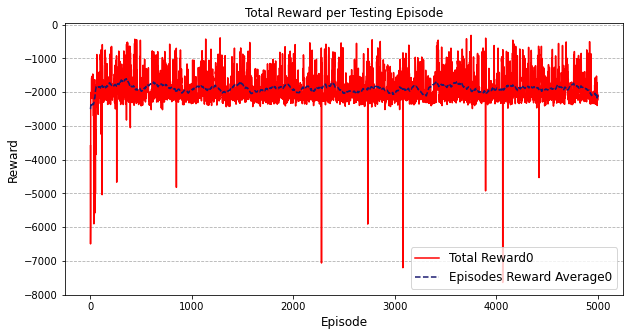

In [38]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

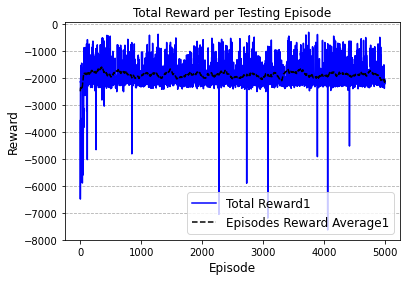

In [39]:
plt.plot(no_episodes,rewards_1, color = 'blue',  linestyle = '-', 
        label = 'Total Reward1')
plt.plot(no_episodes, avg_rewards_1, color = 'black',  linestyle = '--', 
        label = 'Episodes Reward Average1')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()


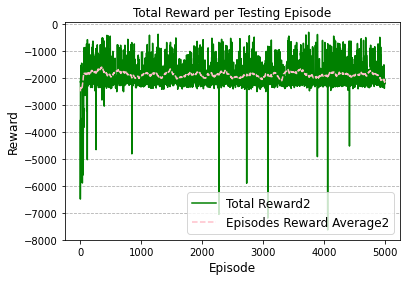

In [40]:
plt.plot(no_episodes,rewards_2, color = 'green',  linestyle = '-', 
        label = 'Total Reward2')
plt.plot(no_episodes, avg_rewards_2, color = 'pink',  linestyle = '--', 
        label = 'Episodes Reward Average2')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [42]:
total_avg_reward=[]

In [43]:
for i in range(0,5000):
    k=np.mean(rewards_0[i]+rewards_1[i]+rewards_2[i])
    k=np.round(k,3)
    total_avg_reward.append(k)

In [47]:
avg_total=[]

In [48]:
for i in range(0,5000):
    k=np.mean(total_avg_reward[i:i+100])
    k=np.round(k,3)
    avg_total.append(k)

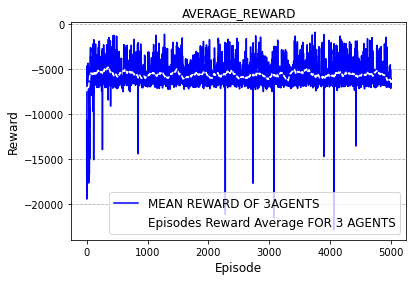

In [50]:
plt.plot(no_episodes,total_avg_reward, color = 'blue',  linestyle = '-', 
        label = 'MEAN REWARD OF 3AGENTS')
plt.plot(no_episodes, avg_total, color = 'white',  linestyle = '--', 
        label = 'Episodes Reward Average FOR 3 AGENTS')

plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('AVERAGE_REWARD',fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [53]:
agent1.critic.get_weights()

[array([[-0.06968175, -0.75269756,  0.39852087, ..., -1.25705924,
         -0.39157565, -0.46671724],
        [ 1.26412938,  0.03512514, -0.52930305, ..., -1.17183239,
         -1.25261376, -2.44289913],
        [ 0.76030083, -0.11640177, -0.14115458, ..., -0.07867321,
          0.14315202, -0.85752762],
        ...,
        [-0.14684415, -0.12032969,  0.21038535, ...,  0.06107674,
         -0.18861716,  0.20205981],
        [ 0.03045752, -0.11777324,  0.21558118, ...,  0.19199288,
         -0.10844514,  0.14946543],
        [ 0.24324705, -0.11913122,  0.21530383, ..., -0.05083128,
         -0.01541962, -0.19810665]]),
 array([-4.65605092, -1.62695704, -3.5288136 , -3.76113415, -3.56873427,
        -1.96950839, -4.16435854, -4.44678433, -1.95483806, -3.69290078,
        -2.99113088, -2.83709806, -1.53182493, -2.83990375, -3.88596579,
        -5.74028386, -1.55764237, -2.38278837, -4.02641954,  4.16359805,
        -2.00242079, -2.00161267, -3.02029879, -2.89172787, -3.57025925,
        

In [54]:
agent1.actor_models['agent_0'].get_weights()

[array([[-0.14500352,  0.0574588 , -0.16761116, ...,  0.04898883,
         -0.06626481,  0.1465847 ],
        [-0.16594039, -0.13022318,  0.11828026, ...,  0.07869119,
          0.08188279, -0.05867676],
        [ 0.05200235, -0.00933642, -0.10616221, ...,  0.01877499,
         -0.04555682, -0.13632428],
        ...,
        [-0.05130496, -0.10364275,  0.0331977 , ..., -0.0313709 ,
          0.01493104, -0.09264451],
        [ 0.113659  , -0.12950705,  0.06156559, ...,  0.04113392,
         -0.11907466, -0.02912617],
        [ 0.1315319 , -0.13087202,  0.07390314, ..., -0.0462543 ,
          0.13292922,  0.11310228]]),
 array([-1.62733666e-01, -6.89057814e-02, -1.32997215e-01, -5.51322781e-01,
         1.64119701e-01, -2.33536646e-01, -2.56165110e-01, -1.03813195e-01,
        -2.82591152e-01, -6.69429610e-01, -1.68274901e-01, -5.91130492e-01,
        -3.14768703e-01, -6.04826962e-01, -7.00842599e-01,  1.07518994e-01,
         2.99956452e-01,  4.92421114e-01, -6.54132933e-01,  2.4033928

In [55]:
agent1.actor_models['agent_1'].get_weights()

[array([[-0.30420207, -0.14792693,  0.18022483, ..., -0.35318334,
         -0.19552467, -0.26300556],
        [-0.21684863, -0.36961698,  0.18049288, ..., -0.3495589 ,
         -0.02666623, -0.21286264],
        [-0.09356007, -0.11942993,  0.19743106, ..., -0.13581065,
          0.0339102 , -0.10533723],
        ...,
        [ 0.05496119,  0.14506953,  0.14676468, ..., -0.06154689,
         -0.01599612,  0.02941369],
        [ 0.09826794, -0.13400653, -0.01790918, ...,  0.04319218,
         -0.0425765 , -0.04934039],
        [ 0.0825584 ,  0.0977352 ,  0.12409822, ..., -0.03304252,
         -0.0662234 , -0.02421432]]),
 array([-0.71995066, -0.4056791 ,  0.65821421,  0.43679039,  1.03733053,
        -0.2780735 ,  0.24392536, -1.20367699, -0.0047245 , -0.48120788,
        -0.06730132,  0.15071362, -0.49037044, -0.3179608 , -0.79587912,
         0.21317866, -0.29168858, -0.41135825,  0.07383678, -1.05736975,
         0.0882703 ,  0.34273624,  0.12785686, -0.33899342, -0.33962318,
        

In [56]:
agent1.actor_models['agent_2'].get_weights()

[array([[ 0.11833136, -0.28691307, -0.31142007, ..., -0.0345036 ,
          0.07769684, -0.0047192 ],
        [ 0.11763807, -0.23906487, -0.30890833, ...,  0.04532568,
          0.08482877,  0.18257702],
        [-0.0198635 ,  0.05673528,  0.08069255, ..., -0.05168099,
         -0.01101806,  0.02839958],
        ...,
        [-0.14779614, -0.08509947, -0.14672851, ...,  0.04567376,
          0.08307831,  0.13041911],
        [ 0.0726841 ,  0.14194629, -0.0257231 , ..., -0.12227011,
         -0.14349323,  0.14160717],
        [ 0.11498866, -0.09216965, -0.06223258, ...,  0.01703464,
          0.01068362, -0.04326924]]),
 array([-7.85418132e-02, -7.13206225e-01, -4.94772017e-01, -1.13115705e+00,
        -1.01548375e+00, -3.37442275e-01,  4.49374967e-01,  2.15073200e-01,
        -2.40076222e-01, -3.27509202e-01, -6.55880847e-02, -6.51535389e-03,
        -1.51695518e-01, -1.25248517e-01, -2.93355338e-01,  1.54367065e-01,
        -1.12733936e+00, -1.97198621e-01, -2.02000384e-01, -7.1540106

In [57]:
agent1.actor_models['agent_0'].save('AGENT_0.h5')

In [58]:
from tensorflow.keras.models import load_model

In [59]:
model=load_model('AGENT_0.h5')

In [63]:
agent1.actor_models['agent_1'].save('AGENT_1.h5')

In [64]:
agent1.actor_models['agent_2'].save('AGENT_2.h5')

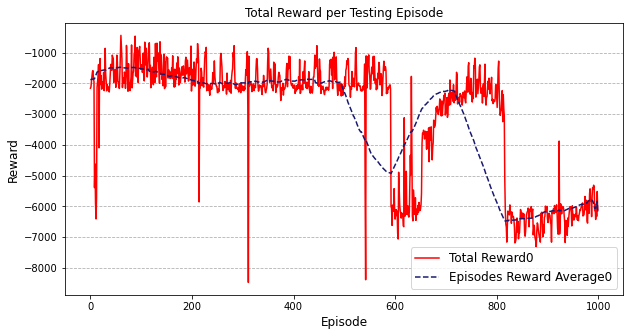

In [24]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,rewards_0, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_rewards_0, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()